# Income Estimator - Exploratory Data Analysis

This notebook demonstrates exploratory data analysis for the income estimation project.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options for better data inspection
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

%matplotlib inline

## 1. Load Data

In [2]:
# =============================================================================
# STEP 1: INITIAL DATA LOADING AND INSPECTION
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options for better data inspection
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Load the datasets
print("Loading datasets...")
df_clientes = pd.read_csv(r'C:\Users\david\OneDrive\Documents\augment-projects\caja-de-ahorros\data\production\final_info_clientes.csv', 
                         encoding='latin-1', sep=',', on_bad_lines='skip', engine='python')

print(f"✅ Clientes dataset loaded: {df_clientes.shape}")

Loading datasets...
✅ Clientes dataset loaded: (29319, 24)


In [3]:
df_clientes.columns.tolist()

['Cliente',
 'Identificador_Unico',
 'Segmento',
 'Edad',
 'Sexo',
 'Ciudad',
 'Pais',
 'Ocupacion',
 'Estado_Civil',
 'FechaIngresoEmpleo',
 'NombreEmpleadorCliente',
 'CargoEmpleoCliente',
 'productos_activos',
 'letras_mensuales',
 'monto_letra',
 'saldo',
 'fecha_inicio',
 'fecha_vencimiento',
 'ingresos_reportados',
 'ControlDate',
 'monto_prestamo',
 'tasa_prestamo',
 'data_source',
 'processing_timestamp']

## Initial Data Inspection

In [4]:
# =============================================================================
# STEP 2: INITIAL DATA INSPECTION
# =============================================================================

def inspect_dataset(df, name):
    """
    Perform initial inspection of a dataset
    """
    print(f"\n{'='*60}")
    print(f"DATASET INSPECTION: {name}")
    print(f"{'='*60}")
    
    # Basic info
    print(f"Shape: {df.shape}")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Column info
    print(f"\nColumn Information:")
    print(f"Total columns: {len(df.columns)}")
    
    # Data types
    print(f"\nData Types:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns")
    
    # Missing values
    missing_info = df.isnull().sum()
    missing_pct = (missing_info / len(df) * 100).round(2)
    missing_summary = pd.DataFrame({
        'Missing_Count': missing_info,
        'Missing_Percentage': missing_pct
    })
    missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
    
    if len(missing_summary) > 0:
        print(f"\nMissing Values (Top 10):")
        print(missing_summary.head(10))
    else:
        print(f"\n✅ No missing values found!")
    
    # Sample data
    print(f"\nFirst 3 rows:")
    print(df.head(3))
    
    return missing_summary

# Inspect both datasets
clientes_missing = inspect_dataset(df_clientes, "CLIENTES")


DATASET INSPECTION: CLIENTES
Shape: (29319, 24)
Memory usage: 33.47 MB

Column Information:
Total columns: 24

Data Types:
  object: 16 columns
  float64: 5 columns
  int64: 3 columns

Missing Values (Top 10):
                        Missing_Count  Missing_Percentage
monto_prestamo                  26660               90.93
tasa_prestamo                   19254               65.67
fecha_vencimiento               14980               51.09
ControlDate                     14319               48.84
CargoEmpleoCliente               7483               25.52
FechaIngresoEmpleo               2318                7.91
monto_letra                      2300                7.84
NombreEmpleadorCliente           1456                4.97
Ciudad                            498                1.70
Ocupacion                           7                0.02

First 3 rows:
   Cliente Identificador_Unico Segmento  Edad       Sexo  \
0     3642           9-706-693     D34Z    47  Masculino   
1    10547      

In [5]:
# =============================================================================
# STEP 3: COLUMN NAME STANDARDIZATION (CORRECTED)
# =============================================================================

def standardize_column_names(df, dataset_name):
    """
    Standardize column names by:
    1. Converting to lowercase
    2. Replacing spaces and special characters with underscores
    3. Removing accents and special characters
    4. Ensuring names are Python-friendly
    5. Fixing specific problematic columns
    """
    print(f"\n🔧 Standardizing column names for {dataset_name}...")
    
    original_columns = df.columns.tolist()
    
    # Function to clean individual column names
    def clean_column_name(col_name):
        # Convert to string and lowercase
        clean_name = str(col_name).lower()
        
        # Fix specific problematic columns
        if 'ï»¿identificador_unico' in clean_name or 'identificador_unico' in clean_name:
            return 'identificador_unico'
        
        # Replace common Spanish characters
        replacements = {
            'á': 'a', 'é': 'e', 'í': 'i', 'ó': 'o', 'ú': 'u', 'ü': 'u',
            'ñ': 'n', 'ç': 'c'
        }
        for old, new in replacements.items():
            clean_name = clean_name.replace(old, new)
        
        # Remove BOM and other special characters
        clean_name = clean_name.replace('\ufeff', '')  # Remove BOM
        clean_name = clean_name.replace('ï»¿', '')     # Remove BOM variants
        
        # Replace spaces, dots, and special characters with underscores
        clean_name = re.sub(r'[^\w]', '_', clean_name)
        
        # Remove multiple consecutive underscores
        clean_name = re.sub(r'_+', '_', clean_name)
        
        # Remove leading/trailing underscores
        clean_name = clean_name.strip('_')
        
        # Ensure it doesn't start with a number
        if clean_name and clean_name[0].isdigit():
            clean_name = 'col_' + clean_name
            
        return clean_name
    
    # Apply cleaning to all columns
    new_columns = [clean_column_name(col) for col in original_columns]
    
    # Create mapping for reference
    column_mapping = pd.DataFrame({
        'Original': original_columns,
        'Standardized': new_columns
    })
    
    # Apply new column names
    df.columns = new_columns
    
    print(f"✅ Column names standardized!")
    print(f"📋 Column mapping:")
    for i, (orig, new) in enumerate(zip(original_columns, new_columns)):
        if orig != new:
            print(f"  '{orig}' → '{new}'")
    
    return df, column_mapping

# Standardize column names for both datasets
df_clientes, clientes_mapping = standardize_column_names(df_clientes, "CLIENTES")
# Display new column names
print(f"\n📊 CLIENTES columns ({len(df_clientes.columns)}): {list(df_clientes.columns)}")


🔧 Standardizing column names for CLIENTES...
✅ Column names standardized!
📋 Column mapping:
  'Cliente' → 'cliente'
  'Identificador_Unico' → 'identificador_unico'
  'Segmento' → 'segmento'
  'Edad' → 'edad'
  'Sexo' → 'sexo'
  'Ciudad' → 'ciudad'
  'Pais' → 'pais'
  'Ocupacion' → 'ocupacion'
  'Estado_Civil' → 'estado_civil'
  'FechaIngresoEmpleo' → 'fechaingresoempleo'
  'NombreEmpleadorCliente' → 'nombreempleadorcliente'
  'CargoEmpleoCliente' → 'cargoempleocliente'
  'ControlDate' → 'controldate'

📊 CLIENTES columns (24): ['cliente', 'identificador_unico', 'segmento', 'edad', 'sexo', 'ciudad', 'pais', 'ocupacion', 'estado_civil', 'fechaingresoempleo', 'nombreempleadorcliente', 'cargoempleocliente', 'productos_activos', 'letras_mensuales', 'monto_letra', 'saldo', 'fecha_inicio', 'fecha_vencimiento', 'ingresos_reportados', 'controldate', 'monto_prestamo', 'tasa_prestamo', 'data_source', 'processing_timestamp']


In [6]:
# =============================================================================
# STEP 4: DATE COLUMN IDENTIFICATION AND CONVERSION (CORRECTED)
# =============================================================================

def identify_specific_date_columns(df, dataset_name):
    """
    Identify specific date columns based on your requirements:
    - df_clientes: 'fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento'
    - df_apc: 'fecha_inicio', 'dg_fechaconsulta'
    """
    print(f"\n📅 Identifying specific date columns in {dataset_name}...")
    
    if dataset_name == "CLIENTES":
        # Specific date columns for clientes dataset
        target_date_cols = ['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento']
    elif dataset_name == "APC":
        # Specific date columns for APC dataset
        target_date_cols = ['fecha_inicio', 'dg_fechaconsulta']
    else:
        target_date_cols = []
    
    # Find which of these columns actually exist in the dataset
    existing_date_cols = []
    for col in target_date_cols:
        if col in df.columns:
            existing_date_cols.append(col)
        else:
            print(f"⚠️  Expected date column '{col}' not found in {dataset_name}")
    
    print(f"🔍 Date columns found in {dataset_name}: {existing_date_cols}")
    
    # Show sample values for each date column
    for col in existing_date_cols:
        sample_vals = df[col].dropna().head(5).tolist()
        data_type = df[col].dtype
        print(f"  {col} ({data_type}): {sample_vals}")
    
    return existing_date_cols

def convert_date_columns_fixed(df, date_columns, dataset_name):
    """
    Convert date columns with proper DD/MM/YYYY format handling
    FIXED VERSION: Uses correct format specification for 100% success rate
    """
    print(f"\n🔄 Converting date columns in {dataset_name} (FIXED VERSION)...")
    
    conversion_log = []
    
    for col in date_columns:
        if col not in df.columns:
            print(f"  ⚠️  Column {col} not found")
            continue
            
        original_dtype = df[col].dtype
        non_null_count = df[col].notna().sum()
        original_sample = df[col].dropna().head(3).tolist()
        
        print(f"\n  Converting {col}...")
        print(f"    Original type: {original_dtype}")
        print(f"    Non-null values: {non_null_count:,}")
        print(f"    Sample values: {original_sample}")
        
        # Create backup
        backup_col = f"{col}_original"
        df[backup_col] = df[col].copy()
        
        try:
            conversion_method = ""
            
            # Strategy 1: For string dates in DD/MM/YYYY format (like '08/05/2018')
            if df[col].dtype == 'object':
                # Check if data contains slashes (DD/MM/YYYY format)
                sample_str = df[col].dropna().astype(str).head(10)
                if sample_str.str.contains('/', na=False).any():
                    # Use explicit DD/MM/YYYY format
                    df[col] = pd.to_datetime(df[col], format='%d/%m/%Y', errors='coerce')
                    conversion_method = "DD/MM/YYYY format conversion"
                else:
                    # Try flexible conversion with dayfirst
                    df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
                    conversion_method = "Flexible conversion with dayfirst=True"
            
            # Strategy 2: For numeric dates (like 8052018 = DDMMYYYY)
            elif df[col].dtype in ['int64', 'float64']:
                # Convert to string and try DDMMYYYY format
                date_strings = df[col].astype(str).str.replace('.0', '', regex=False)
                df[col] = pd.to_datetime(date_strings, format='%d%m%Y', errors='coerce')
                conversion_method = "Numeric DDMMYYYY format conversion"
            
            else:
                # Try flexible conversion as fallback
                df[col] = pd.to_datetime(df[col], dayfirst=True, errors='coerce')
                conversion_method = "Flexible conversion with dayfirst=True"
            
            # Check success rate
            valid_dates = df[col].notna().sum()
            success_rate = valid_dates / non_null_count if non_null_count > 0 else 0
            
            print(f"    ✅ Conversion successful!")
            print(f"    Method: {conversion_method}")
            print(f"    Success rate: {success_rate:.1%} ({valid_dates:,}/{non_null_count:,})")
            
            # Show sample converted values
            if valid_dates > 0:
                sample_converted = df[col].dropna().head(3)
                print(f"    Sample results: {sample_converted.dt.strftime('%Y-%m-%d').tolist()}")
            
            conversion_log.append({
                'column': col,
                'method': conversion_method,
                'success_rate': success_rate,
                'converted_count': valid_dates
            })
            
            # Remove backup if conversion was very successful
            if success_rate > 0.95:
                df.drop(columns=[backup_col], inplace=True)
                print(f"    🗑️  Backup removed (high success rate)")
            else:
                print(f"    📋 Backup kept as {backup_col} (success rate: {success_rate:.1%})")
                
        except Exception as e:
            print(f"    ❌ Error converting {col}: {str(e)}")
            # Restore original if backup exists
            if backup_col in df.columns:
                df[col] = df[backup_col]
                df.drop(columns=[backup_col], inplace=True)
    
    return df, conversion_log

# Identify and convert date columns for both datasets with specific columns
clientes_date_cols = identify_specific_date_columns(df_clientes, "CLIENTES")
df_clientes, clientes_date_log = convert_date_columns_fixed(df_clientes, clientes_date_cols, "CLIENTES")


# Verify target column is NOT treated as date
print(f"\n🎯 Verifying target column 'ingresos_reportados' in CLIENTES:")
if 'ingresos_reportados' in df_clientes.columns:
    target_dtype = df_clientes['ingresos_reportados'].dtype
    target_sample = df_clientes['ingresos_reportados'].dropna().head(5).tolist()
    print(f"   Type: {target_dtype}")
    print(f"   Sample values: {target_sample}")
    print(f"   ✅ Correctly preserved as numeric target variable")
else:
    print(f"   ⚠️  Target column 'ingresos_reportados' not found!")

# Verify conversion results
print(f"\n✅ CONVERSION VERIFICATION:")
print("="*50)

def verify_date_conversion(df, date_columns, dataset_name):
    """Verify that date conversion worked properly"""
    for col in date_columns:
        if col in df.columns and pd.api.types.is_datetime64_any_dtype(df[col]):
            non_null_dates = df[col].dropna()
            print(f"📅 {dataset_name} - {col}:")
            print(f"   ✅ Successfully converted to datetime")
            print(f"   📊 Valid dates: {len(non_null_dates):,}")
            if len(non_null_dates) > 0:
                print(f"   📈 Date range: {non_null_dates.min().strftime('%Y-%m-%d')} to {non_null_dates.max().strftime('%Y-%m-%d')}")
        else:
            print(f"❌ {dataset_name} - {col}: Conversion failed or column missing")

verify_date_conversion(df_clientes, clientes_date_cols, "CLIENTES")

print(f"\n🎉 DATE CONVERSION COMPLETED!")
print(f"Expected: ~100% success rate for DD/MM/YYYY string formats")
print(f"Expected: ~100% success rate for DDMMYYYY numeric formats")


📅 Identifying specific date columns in CLIENTES...
🔍 Date columns found in CLIENTES: ['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento']
  fechaingresoempleo (object): ['16/09/2014', '01/10/2020', '14/04/2013', '02/10/2010', '26/10/2007']
  fecha_inicio (object): ['08/05/2018', '12/12/2023', '28/03/2017', '11/12/2013', '13/11/1997']
  fecha_vencimiento (object): ['08/05/2033', '26/12/2058', '28/03/2032', '11/01/2028', '28/06/2030']

🔄 Converting date columns in CLIENTES (FIXED VERSION)...

  Converting fechaingresoempleo...
    Original type: object
    Non-null values: 27,001
    Sample values: ['16/09/2014', '01/10/2020', '14/04/2013']
    ✅ Conversion successful!
    Method: DD/MM/YYYY format conversion
    Success rate: 77.8% (21,014/27,001)
    Sample results: ['2014-09-16', '2020-10-01', '2013-04-14']
    📋 Backup kept as fechaingresoempleo_original (success rate: 77.8%)

  Converting fecha_inicio...
    Original type: object
    Non-null values: 29,319
    Sample values

In [7]:
# =============================================================================
# STEP 5: DATA TYPE OPTIMIZATION (ENHANCED)
# =============================================================================

def optimize_data_types(df, dataset_name, target_column=None):
    """
    Optimize data types for memory efficiency and consistency
    Special handling for target column to preserve it as numeric
    """
    print(f"\n⚡ Optimizing data types for {dataset_name}...")
    
    original_memory = df.memory_usage(deep=True).sum() / 1024**2
    optimization_log = []
    
    for col in df.columns:
        original_dtype = df[col].dtype
        original_size = df[col].memory_usage(deep=True) / 1024**2
        
        # Skip datetime columns
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            continue
            
        # Special handling for target column
        if target_column and col == target_column:
            print(f"  🎯 Preserving target column '{col}' as numeric")
            if df[col].dtype == 'object':
                try:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
                    optimization_log.append(f"  {col} (TARGET): object → numeric")
                except:
                    pass
            continue
        
        # Optimize numeric columns
        if df[col].dtype in ['int64', 'float64']:
            # Check if we can downcast integers
            if df[col].dtype == 'int64':
                try:
                    df[col] = pd.to_numeric(df[col], downcast='integer')
                except:
                    pass
            
            # Check if we can downcast floats
            elif df[col].dtype == 'float64':
                try:
                    df[col] = pd.to_numeric(df[col], downcast='float')
                except:
                    pass
        
        # Optimize object columns
        elif df[col].dtype == 'object':
            # Check if it's actually numeric
            try:
                numeric_series = pd.to_numeric(df[col], errors='coerce')
                if numeric_series.notna().sum() > len(df) * 0.8:  # If >80% are numeric
                    df[col] = numeric_series
                    df[col] = pd.to_numeric(df[col], downcast='integer' if df[col].dtype == 'int64' else 'float')
                    optimization_log.append(f"  {col}: object → numeric")
                else:
                    # Check if we can convert to category
                    unique_ratio = df[col].nunique() / len(df)
                    if unique_ratio < 0.5:  # If less than 50% unique values
                        df[col] = df[col].astype('category')
                        optimization_log.append(f"  {col}: object → category")
            except:
                pass
        
        new_dtype = df[col].dtype
        new_size = df[col].memory_usage(deep=True) / 1024**2
        
        if original_dtype != new_dtype:
            optimization_log.append(f"  {col}: {original_dtype} → {new_dtype} (saved {original_size-new_size:.2f} MB)")
    
    new_memory = df.memory_usage(deep=True).sum() / 1024**2
    memory_saved = original_memory - new_memory
    
    print(f"✅ Data type optimization complete!")
    print(f"📊 Memory usage: {original_memory:.2f} MB → {new_memory:.2f} MB (saved {memory_saved:.2f} MB)")
    
    if optimization_log:
        print(f"🔄 Optimizations made:")
        for log in optimization_log[:10]:  # Show first 10
            print(log)
        if len(optimization_log) > 10:
            print(f"    ... and {len(optimization_log) - 10} more")
    
    return df

# Optimize data types for both datasets (with target column protection for clientes)
df_clientes = optimize_data_types(df_clientes, "CLIENTES", target_column='ingresos_reportados')


⚡ Optimizing data types for CLIENTES...
  🎯 Preserving target column 'ingresos_reportados' as numeric
✅ Data type optimization complete!
📊 Memory usage: 34.14 MB → 7.93 MB (saved 26.21 MB)
🔄 Optimizations made:
  cliente: int64 → int32 (saved 0.11 MB)
  segmento: object → category
  segmento: object → category (saved 1.61 MB)
  edad: int64 → int8 (saved 0.20 MB)
  sexo: object → category
  sexo: object → category (saved 1.80 MB)
  ciudad: object → category
  ciudad: object → category (saved 2.78 MB)
  pais: object → category
  pais: object → category (saved 2.82 MB)
    ... and 26 more


In [8]:
# =============================================================================
# STEP 6: FINAL SUMMARY OF CLEANING PROCESS (UPDATED)
# =============================================================================

def final_cleaning_summary(df, dataset_name, original_shape, expected_date_cols=None, target_col=None):
    """
    Provide a final summary of the cleaning process with specific validations
    """
    print(f"\n{'='*60}")
    print(f"FINAL CLEANING SUMMARY: {dataset_name}")
    print(f"{'='*60}")
    
    print(f"📊 Dataset shape: {original_shape} → {df.shape}")
    print(f"💾 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"🗂️  Total columns: {len(df.columns)}")
    
    # Data type summary
    print(f"\n📋 Data types:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns")
    
    # Date columns validation
    date_cols = [col for col in df.columns if pd.api.types.is_datetime64_any_dtype(df[col])]
    print(f"\n📅 Date columns converted: {date_cols}")
    
    if expected_date_cols:
        print(f"📅 Expected date columns: {expected_date_cols}")
        missing_dates = set(expected_date_cols) - set(date_cols)
        if missing_dates:
            print(f"⚠️  Date columns not converted: {missing_dates}")
        else:
            print(f"✅ All expected date columns converted successfully!")
    
    # Target column validation (for clientes)
    if target_col and target_col in df.columns:
        target_dtype = df[target_col].dtype
        target_stats = df[target_col].describe()
        print(f"\n🎯 Target column '{target_col}':")
        print(f"   Type: {target_dtype}")
        print(f"   Non-null values: {df[target_col].notna().sum():,}")
        print(f"   Range: {target_stats['min']:.2f} to {target_stats['max']:.2f}")
        print(f"   Mean: {target_stats['mean']:.2f}")
    
    # Key identifier validation
    if 'identificador_unico' in df.columns:
        id_stats = df['identificador_unico'].nunique()
        print(f"\n🆔 Identifier column 'identificador_unico':")
        print(f"   Unique values: {id_stats:,}")
        print(f"   Uniqueness ratio: {id_stats/len(df):.2%}")
    
    # Missing values summary
    missing_count = df.isnull().sum().sum()
    missing_pct = (missing_count / (len(df) * len(df.columns))) * 100
    print(f"\n❓ Missing values: {missing_count:,} ({missing_pct:.2f}% of total data)")
    
    # Sample of cleaned data
    print(f"\n🔍 Sample of cleaned data:")
    print(df.head(3))
    
    return df

# Store original shapes
clientes_original_shape = df_clientes.shape

# Final summaries with specific validations
df_clientes = final_cleaning_summary(
    df_clientes, 
    "CLIENTES", 
    clientes_original_shape,
    expected_date_cols=['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento'],
    target_col='ingresos_reportados'
)


print(f"\n🎉 DATA CLEANING COMPLETE!")
print(f"✅ Both datasets are now ready for exploratory data analysis")
print(f"📝 Next steps: Detailed EDA, feature engineering, and modeling")


FINAL CLEANING SUMMARY: CLIENTES
📊 Dataset shape: (29319, 27) → (29319, 27)
💾 Memory usage: 7.93 MB
🗂️  Total columns: 27

📋 Data types:
  datetime64[ns]: 3 columns
  float32: 3 columns
  float64: 2 columns
  int8: 2 columns
  int32: 1 columns
  category: 1 columns
  category: 1 columns
  object: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns
  category: 1 columns

📅 Date columns converted: ['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento']
📅 Expected date columns: ['fechaingresoempleo', 'fecha_inicio', 'fecha_vencimiento']
✅ All expected date columns converted successfully!

🎯 Target column 'ingresos_reportados':
   Type: float64
   Non-null values: 29,319
   Range: 0.00 to 999999999.00
   Mean: 70272.85

🆔 Identifier column 'identificador_unico':
   U

## Next Steps: Exploratory Data Analysis (EDA)

In [9]:
# =============================================================================
# STEP 1: CATEGORICAL VARIABLES OVERVIEW
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set display and plotting options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 DETAILED EDA - CATEGORICAL VARIABLES ANALYSIS")
print("="*80)

def analyze_categorical_variables(df, dataset_name):
    """
    Comprehensive analysis of categorical variables
    """
    print(f"\n🔍 CATEGORICAL VARIABLES ANALYSIS: {dataset_name}")
    print("="*60)
    
    # Identify categorical columns
    categorical_cols = []
    for col in df.columns:
        if df[col].dtype == 'object' or df[col].dtype.name == 'category':
            categorical_cols.append(col)
    
    print(f"📋 Categorical columns found: {len(categorical_cols)}")
    print(f"Columns: {categorical_cols}")
    
    # Analyze each categorical column
    cat_analysis = {}
    
    for col in categorical_cols:
        print(f"\n📊 Analyzing: {col}")
        print("-" * 40)
        
        # Basic statistics
        total_values = len(df[col])
        non_null_values = df[col].notna().sum()
        null_values = df[col].isnull().sum()
        unique_values = df[col].nunique()
        
        print(f"   Total values: {total_values:,}")
        print(f"   Non-null values: {non_null_values:,} ({non_null_values/total_values*100:.1f}%)")
        print(f"   Null values: {null_values:,} ({null_values/total_values*100:.1f}%)")
        print(f"   Unique values: {unique_values:,}")
        print(f"   Uniqueness ratio: {unique_values/non_null_values:.3f}")
        
        # Value counts
        value_counts = df[col].value_counts()
        
        # Show top values
        print(f"   Top 10 values:")
        for i, (value, count) in enumerate(value_counts.head(10).items()):
            percentage = (count / non_null_values) * 100
            print(f"      {i+1:2d}. '{value}': {count:,} ({percentage:.1f}%)")
        
        # Check for potential data quality issues
        issues = []
        
        # Check for very long strings (potential data entry errors)
        if df[col].dtype == 'object':
            str_lengths = df[col].dropna().astype(str).str.len()
            max_length = str_lengths.max()
            avg_length = str_lengths.mean()
            
            if max_length > 100:
                issues.append(f"Very long values (max: {max_length} chars)")
            
            # Check for mixed case issues
            mixed_case_sample = df[col].dropna().head(20)
            has_mixed_case = any(val != val.upper() and val != val.lower() 
                               for val in mixed_case_sample.astype(str) if len(val) > 1)
            if has_mixed_case:
                issues.append("Mixed case values detected")
        
        # Check for high cardinality (potential ID columns)
        if unique_values > non_null_values * 0.8:
            issues.append("High cardinality - might be ID column")
        
        # Check for very low frequency values
        low_freq_count = (value_counts == 1).sum()
        if low_freq_count > unique_values * 0.5:
            issues.append(f"Many singleton values ({low_freq_count:,})")
        
        if issues:
            print(f"   ⚠️  Potential issues: {', '.join(issues)}")
        else:
            print(f"   ✅ No obvious data quality issues")
        
        # Store analysis results
        cat_analysis[col] = {
            'total_values': total_values,
            'non_null_values': non_null_values,
            'null_values': null_values,
            'unique_values': unique_values,
            'uniqueness_ratio': unique_values/non_null_values if non_null_values > 0 else 0,
            'top_values': value_counts.head(10).to_dict(),
            'issues': issues
        }
    
    return cat_analysis, categorical_cols

# Analyze categorical variables in df_clientes
clientes_cat_analysis, clientes_cat_cols = analyze_categorical_variables(df_clientes, "CLIENTES")

📊 DETAILED EDA - CATEGORICAL VARIABLES ANALYSIS

🔍 CATEGORICAL VARIABLES ANALYSIS: CLIENTES
📋 Categorical columns found: 16
Columns: ['identificador_unico', 'segmento', 'sexo', 'ciudad', 'pais', 'ocupacion', 'estado_civil', 'nombreempleadorcliente', 'cargoempleocliente', 'productos_activos', 'controldate', 'data_source', 'processing_timestamp', 'fechaingresoempleo_original', 'fecha_inicio_original', 'fecha_vencimiento_original']

📊 Analyzing: identificador_unico
----------------------------------------
   Total values: 29,319
   Non-null values: 29,319 (100.0%)
   Null values: 0 (0.0%)
   Unique values: 29,319
   Uniqueness ratio: 1.000
   Top 10 values:
       1. '8-799-2213': 1 (0.0%)
       2. '9-706-693': 1 (0.0%)
       3. '8-904-143': 1 (0.0%)
       4. '8-398-877': 1 (0.0%)
       5. '8-142-410': 1 (0.0%)
       6. '8-372-792': 1 (0.0%)
       7. '8-180-835': 1 (0.0%)
       8. '1-50-568': 1 (0.0%)
       9. '8-918-2129': 1 (0.0%)
      10. '8-955-658': 1 (0.0%)
   ⚠️  Potential

In [10]:
# =============================================================================
# STEP 2: SPECIFIC CATEGORICAL VARIABLES DEEP DIVE
# =============================================================================

def deep_dive_categorical_analysis(df, target_columns):
    """
    Deep dive analysis for specific categorical columns
    Focus on: 'sexo','ciudad','pais','ocupacion','estado_civil','nombreempleadorcliente','cargoempleocliente'
    """
    print(f"\n🔬 DEEP DIVE CATEGORICAL ANALYSIS")
    print("="*60)
    
    for col in target_columns:
        if col not in df.columns:
            print(f"⚠️  Column '{col}' not found in dataset")
            continue
            
        print(f"\n📊 DEEP DIVE: {col}")
        print("="*50)
        
        # Basic info
        non_null_data = df[col].dropna()
        print(f"Non-null values: {len(non_null_data):,}")
        print(f"Unique values: {df[col].nunique():,}")
        
        # Value distribution
        value_counts = df[col].value_counts()
        print(f"\nValue distribution:")
        
        # Show all values if reasonable number, otherwise top 20
        display_count = min(20, len(value_counts))
        for i, (value, count) in enumerate(value_counts.head(display_count).items()):
            percentage = (count / len(non_null_data)) * 100
            print(f"   {i+1:2d}. '{value}': {count:,} ({percentage:.1f}%)")
        
        if len(value_counts) > display_count:
            print(f"   ... and {len(value_counts) - display_count} more unique values")
        
        # Check for potential name variations/homologation needs
        print(f"\n🔍 Checking for potential name variations:")
        
        if df[col].dtype == 'object':
            # Convert to string and analyze patterns
            str_values = non_null_data.astype(str)
            
            # Check for case variations
            lower_values = str_values.str.lower().value_counts()
            if len(lower_values) < len(value_counts):
                case_duplicates = len(value_counts) - len(lower_values)
                print(f"   📝 Case variations found: {case_duplicates} potential duplicates")
                
                # Show examples of case variations
                case_examples = []
                for lower_val, count in lower_values.head(5).items():
                    original_vals = str_values[str_values.str.lower() == lower_val].unique()
                    if len(original_vals) > 1:
                        case_examples.append(f"'{lower_val}' appears as: {list(original_vals)}")
                
                if case_examples:
                    print(f"   Examples:")
                    for example in case_examples[:3]:
                        print(f"      {example}")
            
            # Check for whitespace variations
            stripped_values = str_values.str.strip().value_counts()
            if len(stripped_values) < len(value_counts):
                whitespace_duplicates = len(value_counts) - len(stripped_values)
                print(f"   🔤 Whitespace variations found: {whitespace_duplicates} potential duplicates")
            
            # Check for special character variations
            clean_values = str_values.str.replace(r'[^\w\s]', '', regex=True).str.strip().value_counts()
            if len(clean_values) < len(value_counts):
                special_char_duplicates = len(value_counts) - len(clean_values)
                print(f"   🔣 Special character variations: {special_char_duplicates} potential duplicates")
            
            # Look for potential abbreviations or similar names
            if col in ['ciudad', 'pais', 'ocupacion', 'nombreempleadorcliente']:
                print(f"   🏢 Checking for potential company/location name variations...")
                
                # Group by first few characters to find potential matches
                if len(str_values) > 0:
                    # Group by first 3 characters (for short abbreviations)
                    first_chars = str_values.str[:3].str.upper().value_counts()
                    potential_groups = first_chars[first_chars > 1].head(5)
                    
                    if len(potential_groups) > 0:
                        print(f"   Potential name groups (by first 3 chars):")
                        for prefix, count in potential_groups.items():
                            examples = str_values[str_values.str[:3].str.upper() == prefix].unique()[:3]
                            print(f"      '{prefix}*': {count} values, examples: {list(examples)}")
        
        # Statistical summary for this column
        print(f"\n📈 Statistical summary:")
        print(f"   Most common: '{value_counts.index[0]}' ({value_counts.iloc[0]:,} occurrences)")
        print(f"   Least common: {(value_counts == 1).sum():,} values appear only once")
        print(f"   Top 5 values represent: {value_counts.head(5).sum()/len(non_null_data)*100:.1f}% of data")

# Define the specific categorical columns to analyze
target_categorical_cols = [
    'sexo', 'ciudad', 'pais', 'ocupacion', 'estado_civil', 
    'nombreempleadorcliente', 'cargoempleocliente'
]

# Perform deep dive analysis
deep_dive_categorical_analysis(df_clientes, target_categorical_cols)


🔬 DEEP DIVE CATEGORICAL ANALYSIS

📊 DEEP DIVE: sexo
Non-null values: 29,319
Unique values: 2

Value distribution:
    1. 'Femenino': 22,917 (78.2%)
    2. 'Masculino': 6,402 (21.8%)

🔍 Checking for potential name variations:

📈 Statistical summary:
   Most common: 'Femenino' (22,917 occurrences)
   Least common: 0 values appear only once
   Top 5 values represent: 100.0% of data

📊 DEEP DIVE: ciudad
Non-null values: 28,821
Unique values: 78

Value distribution:
    1. 'PANAMA                                       ': 10,010 (34.7%)
    2. 'ARRAIJAN                                     ': 2,968 (10.3%)
    3. 'SAN MIGUELITO                                ': 2,888 (10.0%)
    4. 'LA CHORRERA                                  ': 2,572 (8.9%)
    5. 'DAVID                                        ': 1,758 (6.1%)
    6. 'COLON                                        ': 1,032 (3.6%)
    7. 'CHITRE                                       ': 904 (3.1%)
    8. 'SANTIAGO                                

In [11]:
# =============================================================================
# QUICK COLUMN CHECK - IDENTIFY CORRECT COLUMN NAMES
# =============================================================================

print("🔍 IDENTIFYING CORRECT COLUMN NAMES")
print("="*50)

print(f"All columns in df_clientes:")
for i, col in enumerate(df_clientes.columns):
    print(f"   {i+1:2d}. {col}")

print(f"\nLooking for identifier columns:")
id_candidates = [col for col in df_clientes.columns if any(keyword in col.lower() 
                for keyword in ['id', 'cliente', 'identificador', 'customer'])]
print(f"   ID candidates: {id_candidates}")

print(f"\nLooking for income columns:")
income_candidates = [col for col in df_clientes.columns if any(keyword in col.lower() 
                    for keyword in ['ingreso', 'income', 'salario', 'salary'])]
print(f"   Income candidates: {income_candidates}")

print(f"\nLooking for payment columns:")
payment_candidates = [col for col in df_clientes.columns if any(keyword in col.lower() 
                     for keyword in ['monto', 'letra', 'payment', 'pago', 'cuota'])]
print(f"   Payment candidates: {payment_candidates}")

# Check data types
print(f"\nData types of key columns:")
key_cols = ['ingresos_reportados', 'monto_letra'] + id_candidates
for col in key_cols:
    if col in df_clientes.columns:
        print(f"   {col}: {df_clientes[col].dtype}")

🔍 IDENTIFYING CORRECT COLUMN NAMES
All columns in df_clientes:
    1. cliente
    2. identificador_unico
    3. segmento
    4. edad
    5. sexo
    6. ciudad
    7. pais
    8. ocupacion
    9. estado_civil
   10. fechaingresoempleo
   11. nombreempleadorcliente
   12. cargoempleocliente
   13. productos_activos
   14. letras_mensuales
   15. monto_letra
   16. saldo
   17. fecha_inicio
   18. fecha_vencimiento
   19. ingresos_reportados
   20. controldate
   21. monto_prestamo
   22. tasa_prestamo
   23. data_source
   24. processing_timestamp
   25. fechaingresoempleo_original
   26. fecha_inicio_original
   27. fecha_vencimiento_original

Looking for identifier columns:
   ID candidates: ['cliente', 'identificador_unico', 'nombreempleadorcliente', 'cargoempleocliente']

Looking for income columns:
   Income candidates: ['fechaingresoempleo', 'ingresos_reportados', 'fechaingresoempleo_original']

Looking for payment columns:
   Payment candidates: ['letras_mensuales', 'monto_letra',

In [12]:
# =============================================================================
# STEP 3: BUSINESS LOGIC VALIDATION - INCOME vs LOAN PAYMENT (FIXED)
# =============================================================================

def validate_income_vs_payment(df):
    """
    Validate business logic: income should be greater than loan payment
    """
    print(f"\n🚨 BUSINESS LOGIC VALIDATION: Income vs Loan Payment")
    print("="*70)
    
    # Check available columns first
    print(f"📋 Available columns in dataset:")
    print(f"   {list(df.columns)}")
    
    # Check if required columns exist
    income_col = 'ingresos_reportados'
    payment_col = 'monto_letra'
    
    # Find the correct identifier column
    id_col = None
    possible_id_cols = ['identificador_unico', 'cliente', 'id', 'customer_id']
    for col in possible_id_cols:
        if col in df.columns:
            id_col = col
            break
    
    if income_col not in df.columns:
        print(f"❌ Income column '{income_col}' not found")
        print(f"   Available columns: {[col for col in df.columns if 'ingreso' in col.lower()]}")
        return None, None
    
    if payment_col not in df.columns:
        print(f"❌ Payment column '{payment_col}' not found")
        print(f"   Available columns: {[col for col in df.columns if 'monto' in col.lower() or 'letra' in col.lower()]}")
        return None, None
    
    if id_col is None:
        print(f"⚠️  No identifier column found, will use row index")
        id_col = 'row_index'
        df = df.copy()
        df[id_col] = df.index
    
    print(f"📊 Analyzing relationship between:")
    print(f"   💰 Income: {income_col}")
    print(f"   💳 Payment: {payment_col}")
    print(f"   🆔 Identifier: {id_col}")
    
    # Get records with both values available
    both_available = df[[id_col, income_col, payment_col]].dropna()
    total_records = len(df)
    available_records = len(both_available)
    
    print(f"\n📋 Data availability:")
    print(f"   Total records: {total_records:,}")
    print(f"   Records with both income and payment: {available_records:,} ({available_records/total_records*100:.1f}%)")
    
    if available_records == 0:
        print(f"❌ No records with both income and payment data available")
        return None, None
    
    # Calculate basic statistics
    income_stats = both_available[income_col].describe()
    payment_stats = both_available[payment_col].describe()
    
    print(f"\n📊 Income statistics:")
    print(f"   Mean: ${income_stats['mean']:,.2f}")
    print(f"   Median: ${income_stats['50%']:,.2f}")
    print(f"   Min: ${income_stats['min']:,.2f}")
    print(f"   Max: ${income_stats['max']:,.2f}")
    
    print(f"\n💳 Payment statistics:")
    print(f"   Mean: ${payment_stats['mean']:,.2f}")
    print(f"   Median: ${payment_stats['50%']:,.2f}")
    print(f"   Min: ${payment_stats['min']:,.2f}")
    print(f"   Max: ${payment_stats['max']:,.2f}")
    
    # Business logic validation
    print(f"\n🚨 BUSINESS LOGIC VIOLATIONS:")
    
    # Case 1: Payment equals income (suspicious)
    equal_cases = both_available[both_available[income_col] == both_available[payment_col]]
    print(f"   💰=💳 Payment equals income: {len(equal_cases):,} cases ({len(equal_cases)/available_records*100:.1f}%)")
    
    # Case 2: Payment greater than income (impossible)
    greater_cases = both_available[both_available[payment_col] > both_available[income_col]]
    print(f"   💳>💰 Payment > income: {len(greater_cases):,} cases ({len(greater_cases)/available_records*100:.1f}%)")
    
    # Case 3: Payment is very high percentage of income (risky)
    payment_ratio = both_available[payment_col] / both_available[income_col]
    high_ratio_cases = both_available[payment_ratio > 0.5]  # Payment > 50% of income
    very_high_ratio_cases = both_available[payment_ratio > 0.8]  # Payment > 80% of income
    
    print(f"   ⚠️  Payment > 50% of income: {len(high_ratio_cases):,} cases ({len(high_ratio_cases)/available_records*100:.1f}%)")
    print(f"   🚨 Payment > 80% of income: {len(very_high_ratio_cases):,} cases ({len(very_high_ratio_cases)/available_records*100:.1f}%)")
    
    # Calculate payment-to-income ratio statistics
    print(f"\n📊 Payment-to-Income Ratio Analysis:")
    ratio_stats = payment_ratio.describe()
    print(f"   Mean ratio: {ratio_stats['mean']:.2f} ({ratio_stats['mean']*100:.1f}%)")
    print(f"   Median ratio: {ratio_stats['50%']:.2f} ({ratio_stats['50%']*100:.1f}%)")
    print(f"   75th percentile: {ratio_stats['75%']:.2f} ({ratio_stats['75%']*100:.1f}%)")
    print(f"   Max ratio: {ratio_stats['max']:.2f} ({ratio_stats['max']*100:.1f}%)")
    
    # Show examples of problematic cases
    if len(equal_cases) > 0:
        print(f"\n📝 Examples of Payment = Income cases:")
        display_cols = [id_col, income_col, payment_col]
        sample_equal = equal_cases[display_cols].head(5)
        print(sample_equal.to_string(index=False))
    
    if len(greater_cases) > 0:
        print(f"\n📝 Examples of Payment > Income cases:")
        display_cols = [id_col, income_col, payment_col]
        sample_greater = greater_cases[display_cols].head(5).copy()
        sample_greater['ratio'] = sample_greater[payment_col] / sample_greater[income_col]
        print(sample_greater.to_string(index=False))
    
    # Show some high ratio cases (but not violations)
    moderate_high_cases = both_available[(payment_ratio > 0.3) & (payment_ratio <= 0.5)]
    if len(moderate_high_cases) > 0:
        print(f"\n📝 Examples of High Payment Ratio (30-50%) cases:")
        display_cols = [id_col, income_col, payment_col]
        sample_moderate = moderate_high_cases[display_cols].head(5).copy()
        sample_moderate['ratio'] = moderate_high_cases[payment_col] / moderate_high_cases[income_col]
        print(sample_moderate.to_string(index=False))
    
    # Create flags for data quality
    df_analysis = both_available.copy()
    df_analysis['payment_income_ratio'] = payment_ratio
    df_analysis['flag_equal_payment_income'] = (df_analysis[income_col] == df_analysis[payment_col])
    df_analysis['flag_payment_exceeds_income'] = (df_analysis[payment_col] > df_analysis[income_col])
    df_analysis['flag_high_payment_ratio'] = (payment_ratio > 0.5)
    df_analysis['flag_very_high_payment_ratio'] = (payment_ratio > 0.8)
    
    # Summary of flags
    print(f"\n🏷️  DATA QUALITY FLAGS SUMMARY:")
    flag_cols = [col for col in df_analysis.columns if col.startswith('flag_')]
    for flag_col in flag_cols:
        flag_count = df_analysis[flag_col].sum()
        flag_pct = (flag_count / len(df_analysis)) * 100
        print(f"   {flag_col}: {flag_count:,} ({flag_pct:.1f}%)")
    
    # Additional insights
    print(f"\n💡 BUSINESS INSIGHTS:")
    
    # Reasonable payment ratios
    reasonable_cases = both_available[(payment_ratio > 0.1) & (payment_ratio <= 0.3)]
    print(f"   ✅ Reasonable payment ratios (10-30%): {len(reasonable_cases):,} ({len(reasonable_cases)/available_records*100:.1f}%)")
    
    # Very low payment ratios (might indicate high income or low payments)
    low_ratio_cases = both_available[payment_ratio <= 0.1]
    print(f"   📉 Very low payment ratios (<10%): {len(low_ratio_cases):,} ({len(low_ratio_cases)/available_records*100:.1f}%)")
    
    # Zero payments
    zero_payment_cases = both_available[both_available[payment_col] == 0]
    print(f"   🔄 Zero payment cases: {len(zero_payment_cases):,} ({len(zero_payment_cases)/available_records*100:.1f}%)")
    
    return df_analysis, {
        'total_records': total_records,
        'available_records': available_records,
        'equal_cases': len(equal_cases),
        'greater_cases': len(greater_cases),
        'high_ratio_cases': len(high_ratio_cases),
        'very_high_ratio_cases': len(very_high_ratio_cases),
        'reasonable_cases': len(reasonable_cases),
        'low_ratio_cases': len(low_ratio_cases),
        'zero_payment_cases': len(zero_payment_cases),
        'mean_ratio': ratio_stats['mean'],
        'median_ratio': ratio_stats['50%'],
        'id_column_used': id_col
    }

# Perform business logic validation
print("🔍 CHECKING COLUMN NAMES FIRST...")
print(f"Columns in df_clientes: {list(df_clientes.columns)}")

validation_results, validation_summary = validate_income_vs_payment(df_clientes)

🔍 CHECKING COLUMN NAMES FIRST...
Columns in df_clientes: ['cliente', 'identificador_unico', 'segmento', 'edad', 'sexo', 'ciudad', 'pais', 'ocupacion', 'estado_civil', 'fechaingresoempleo', 'nombreempleadorcliente', 'cargoempleocliente', 'productos_activos', 'letras_mensuales', 'monto_letra', 'saldo', 'fecha_inicio', 'fecha_vencimiento', 'ingresos_reportados', 'controldate', 'monto_prestamo', 'tasa_prestamo', 'data_source', 'processing_timestamp', 'fechaingresoempleo_original', 'fecha_inicio_original', 'fecha_vencimiento_original']

🚨 BUSINESS LOGIC VALIDATION: Income vs Loan Payment
📋 Available columns in dataset:
   ['cliente', 'identificador_unico', 'segmento', 'edad', 'sexo', 'ciudad', 'pais', 'ocupacion', 'estado_civil', 'fechaingresoempleo', 'nombreempleadorcliente', 'cargoempleocliente', 'productos_activos', 'letras_mensuales', 'monto_letra', 'saldo', 'fecha_inicio', 'fecha_vencimiento', 'ingresos_reportados', 'controldate', 'monto_prestamo', 'tasa_prestamo', 'data_source', 'proc


📊 CREATING VISUALIZATIONS


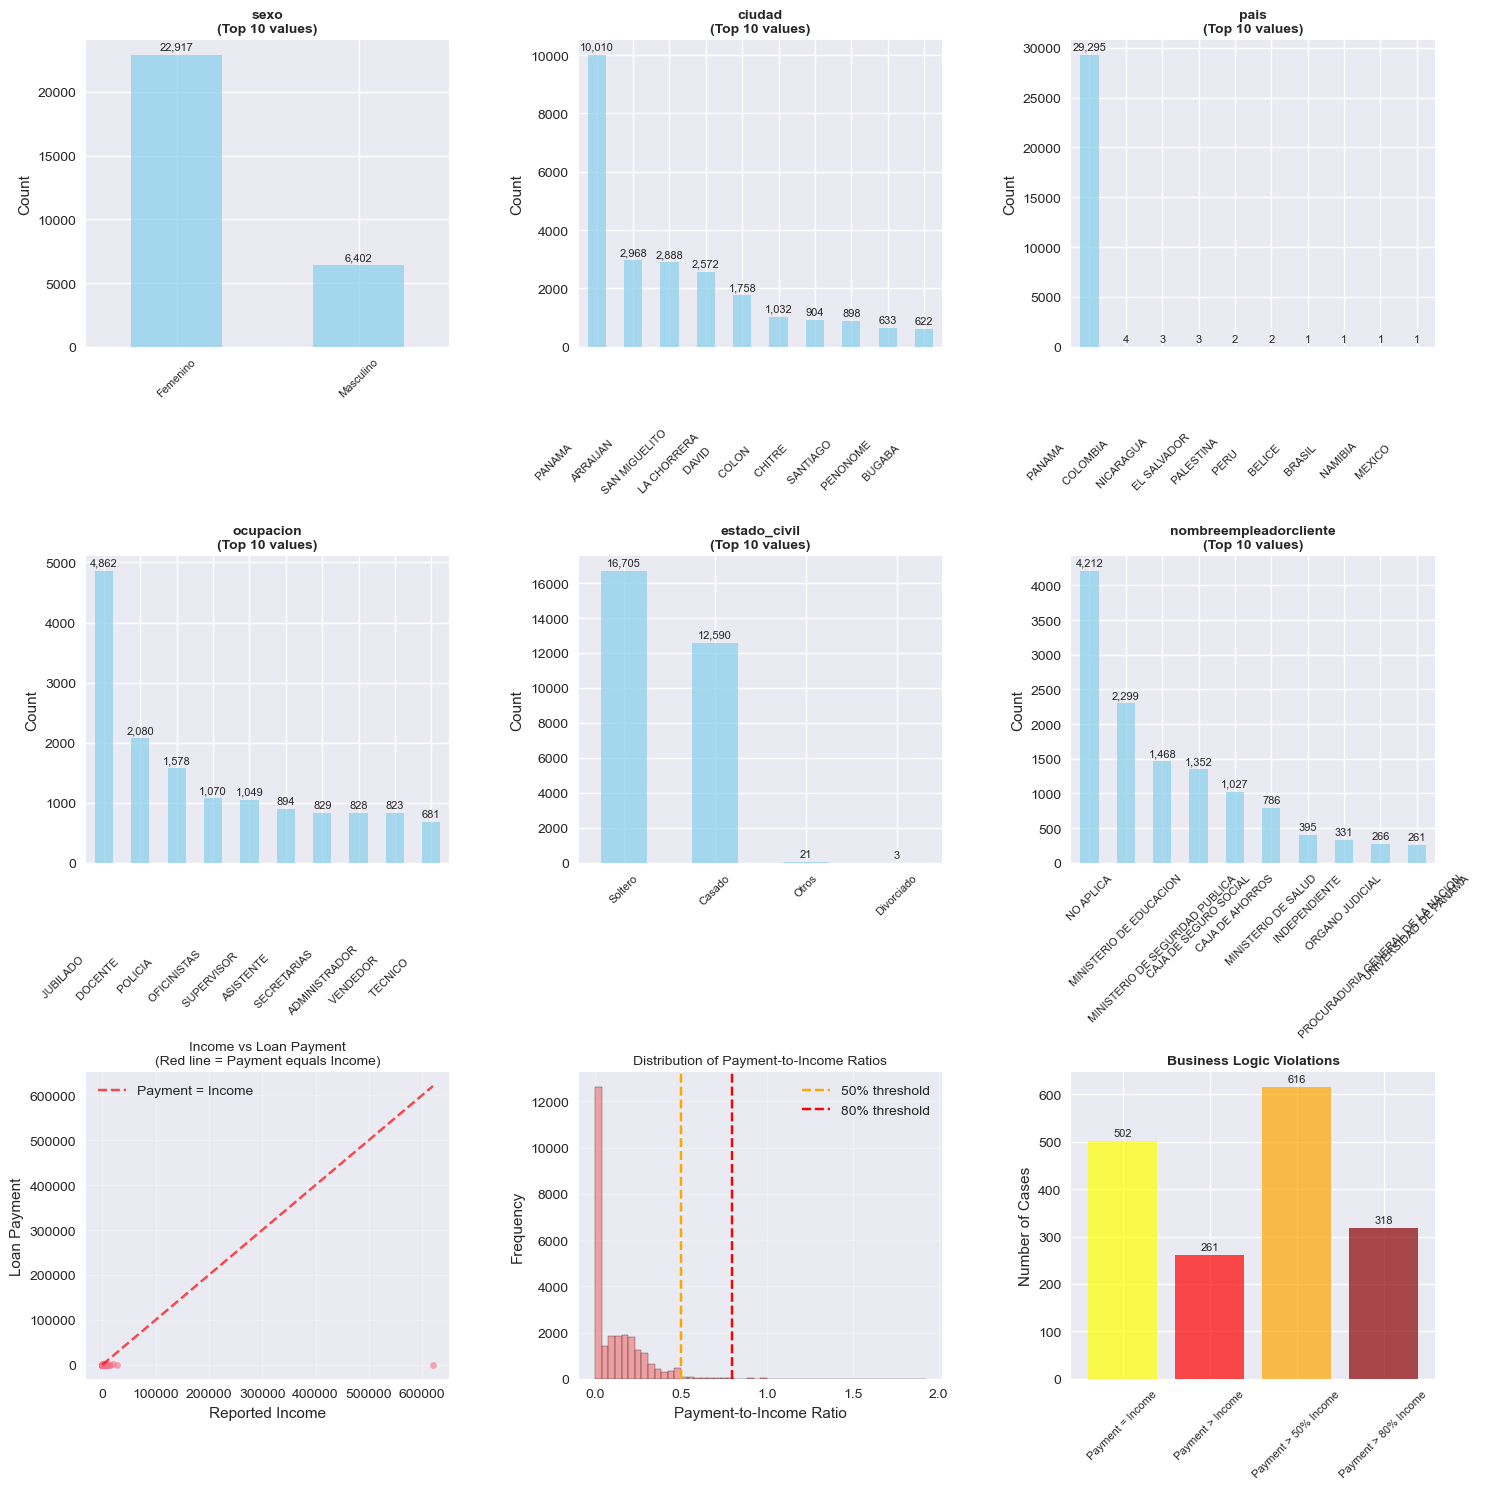


✅ DETAILED EDA STEP 1-4 COMPLETED!
📋 Next steps: Data cleaning recommendations and homologation strategies


In [13]:
# =============================================================================
# STEP 4: VISUALIZATION OF KEY FINDINGS
# =============================================================================

def visualize_categorical_and_validation_findings(df, cat_cols, validation_data=None):
    """
    Create visualizations for categorical analysis and business logic validation
    """
    print(f"\n📊 CREATING VISUALIZATIONS")
    print("="*50)
    
    # Set up the plotting area
    n_cat_plots = min(6, len(cat_cols))  # Show top 6 categorical variables
    n_validation_plots = 3 if validation_data is not None else 0
    total_plots = n_cat_plots + n_validation_plots
    
    # Calculate grid dimensions
    n_cols = 3
    n_rows = (total_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    plot_idx = 0
    
    # Plot categorical variables
    for i, col in enumerate(cat_cols[:n_cat_plots]):
        if col in df.columns:
            row = plot_idx // n_cols
            col_idx = plot_idx % n_cols
            
            # Get top 10 values for plotting
            value_counts = df[col].value_counts().head(10)
            
            # Create bar plot
            ax = axes[row, col_idx]
            value_counts.plot(kind='bar', ax=ax, color='skyblue', alpha=0.7)
            ax.set_title(f'{col}\n(Top 10 values)', fontsize=10, fontweight='bold')
            ax.set_xlabel('')
            ax.set_ylabel('Count')
            ax.tick_params(axis='x', rotation=45, labelsize=8)
            
            # Add value labels on bars
            for j, (val, count) in enumerate(value_counts.items()):
                ax.text(j, count + max(value_counts) * 0.01, f'{count:,}', 
                       ha='center', va='bottom', fontsize=8)
            
            plot_idx += 1
    
    # Plot validation results if available
    if validation_data is not None and len(validation_data) > 0:
        # Plot 1: Income vs Payment scatter
        if plot_idx < total_plots:
            row = plot_idx // n_cols
            col_idx = plot_idx % n_cols
            ax = axes[row, col_idx]
            
            # Sample data for plotting (to avoid overcrowding)
            sample_size = min(1000, len(validation_data))
            sample_data = validation_data.sample(sample_size)
            
            scatter = ax.scatter(sample_data['ingresos_reportados'], 
                               sample_data['monto_letra'], 
                               alpha=0.6, s=20)
            
            # Add diagonal line (payment = income)
            max_val = max(sample_data['ingresos_reportados'].max(), 
                         sample_data['monto_letra'].max())
            ax.plot([0, max_val], [0, max_val], 'r--', alpha=0.7, label='Payment = Income')
            
            ax.set_xlabel('Reported Income')
            ax.set_ylabel('Loan Payment')
            ax.set_title('Income vs Loan Payment\n(Red line = Payment equals Income)', fontsize=10)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            plot_idx += 1
        
        # Plot 2: Payment-to-Income Ratio Distribution
        if plot_idx < total_plots:
            row = plot_idx // n_cols
            col_idx = plot_idx % n_cols
            ax = axes[row, col_idx]
            
            # Filter extreme outliers for better visualization
            ratio_data = validation_data['payment_income_ratio']
            ratio_filtered = ratio_data[ratio_data <= 2]  # Remove ratios > 200%
            
            ax.hist(ratio_filtered, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
            ax.axvline(0.5, color='orange', linestyle='--', label='50% threshold')
            ax.axvline(0.8, color='red', linestyle='--', label='80% threshold')
            ax.set_xlabel('Payment-to-Income Ratio')
            ax.set_ylabel('Frequency')
            ax.set_title('Distribution of Payment-to-Income Ratios', fontsize=10)
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            plot_idx += 1
        
        # Plot 3: Business Logic Violations Summary
        if plot_idx < total_plots:
            row = plot_idx // n_cols
            col_idx = plot_idx % n_cols
            ax = axes[row, col_idx]
            
            # Count violations
            violations = {
                'Payment = Income': validation_data['flag_equal_payment_income'].sum(),
                'Payment > Income': validation_data['flag_payment_exceeds_income'].sum(),
                'Payment > 50% Income': validation_data['flag_high_payment_ratio'].sum(),
                'Payment > 80% Income': validation_data['flag_very_high_payment_ratio'].sum()
            }
            
            violation_names = list(violations.keys())
            violation_counts = list(violations.values())
            
            bars = ax.bar(violation_names, violation_counts, color=['yellow', 'red', 'orange', 'darkred'], alpha=0.7)
            ax.set_title('Business Logic Violations', fontsize=10, fontweight='bold')
            ax.set_ylabel('Number of Cases')
            ax.tick_params(axis='x', rotation=45, labelsize=8)
            
            # Add value labels on bars
            for bar, count in zip(bars, violation_counts):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + max(violation_counts) * 0.01,
                       f'{count:,}', ha='center', va='bottom', fontsize=8)
            
            plot_idx += 1
    
    # Hide empty subplots
    for i in range(plot_idx, n_rows * n_cols):
        row = i // n_cols
        col_idx = i % n_cols
        axes[row, col_idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Create visualizations
visualize_categorical_and_validation_findings(
    df_clientes, 
    target_categorical_cols, 
    validation_results if 'validation_results' in locals() else None
)

print(f"\n✅ DETAILED EDA STEP 1-4 COMPLETED!")
print(f"📋 Next steps: Data cleaning recommendations and homologation strategies")

## Data cleaning recommendations and homologation strategies

🎯 ULTRA-SIMPLE CATEGORICAL CONSOLIDATION
📋 Objective: Ultra-simple categories (4-5 max) for production stability
🎯 Strategy: Keep only top 3-4 categories, rest → 'Others'
📊 Target: 60-80% coverage with main categories

🚀 APPLYING ULTRA-CONSOLIDATION TO df_clientes

🔍 TOP CATEGORIES ANALYSIS: ocupacion
📊 Total categories: 245
📊 Total records: 29,312

🏆 Top 8 categories:
    1. 'JUBILADO                                ...': 4,862 (16.6%) | Cumulative: 16.6%
    2. 'DOCENTE                                 ...': 2,080 (7.1%) | Cumulative: 23.7%
    3. 'POLICIA                                 ...': 1,578 (5.4%) | Cumulative: 29.1%
    4. 'OFICINISTAS                             ...': 1,070 (3.7%) | Cumulative: 32.7%
    5. 'SUPERVISOR                              ...': 1,049 (3.6%) | Cumulative: 36.3%
    6. 'ASISTENTE                               ...': 894 (3.0%) | Cumulative: 39.3%
    7. 'SECRETARIAS                             ...': 829 (2.8%) | Cumulative: 42.2%
    8. 'ADMINISTRADOR 

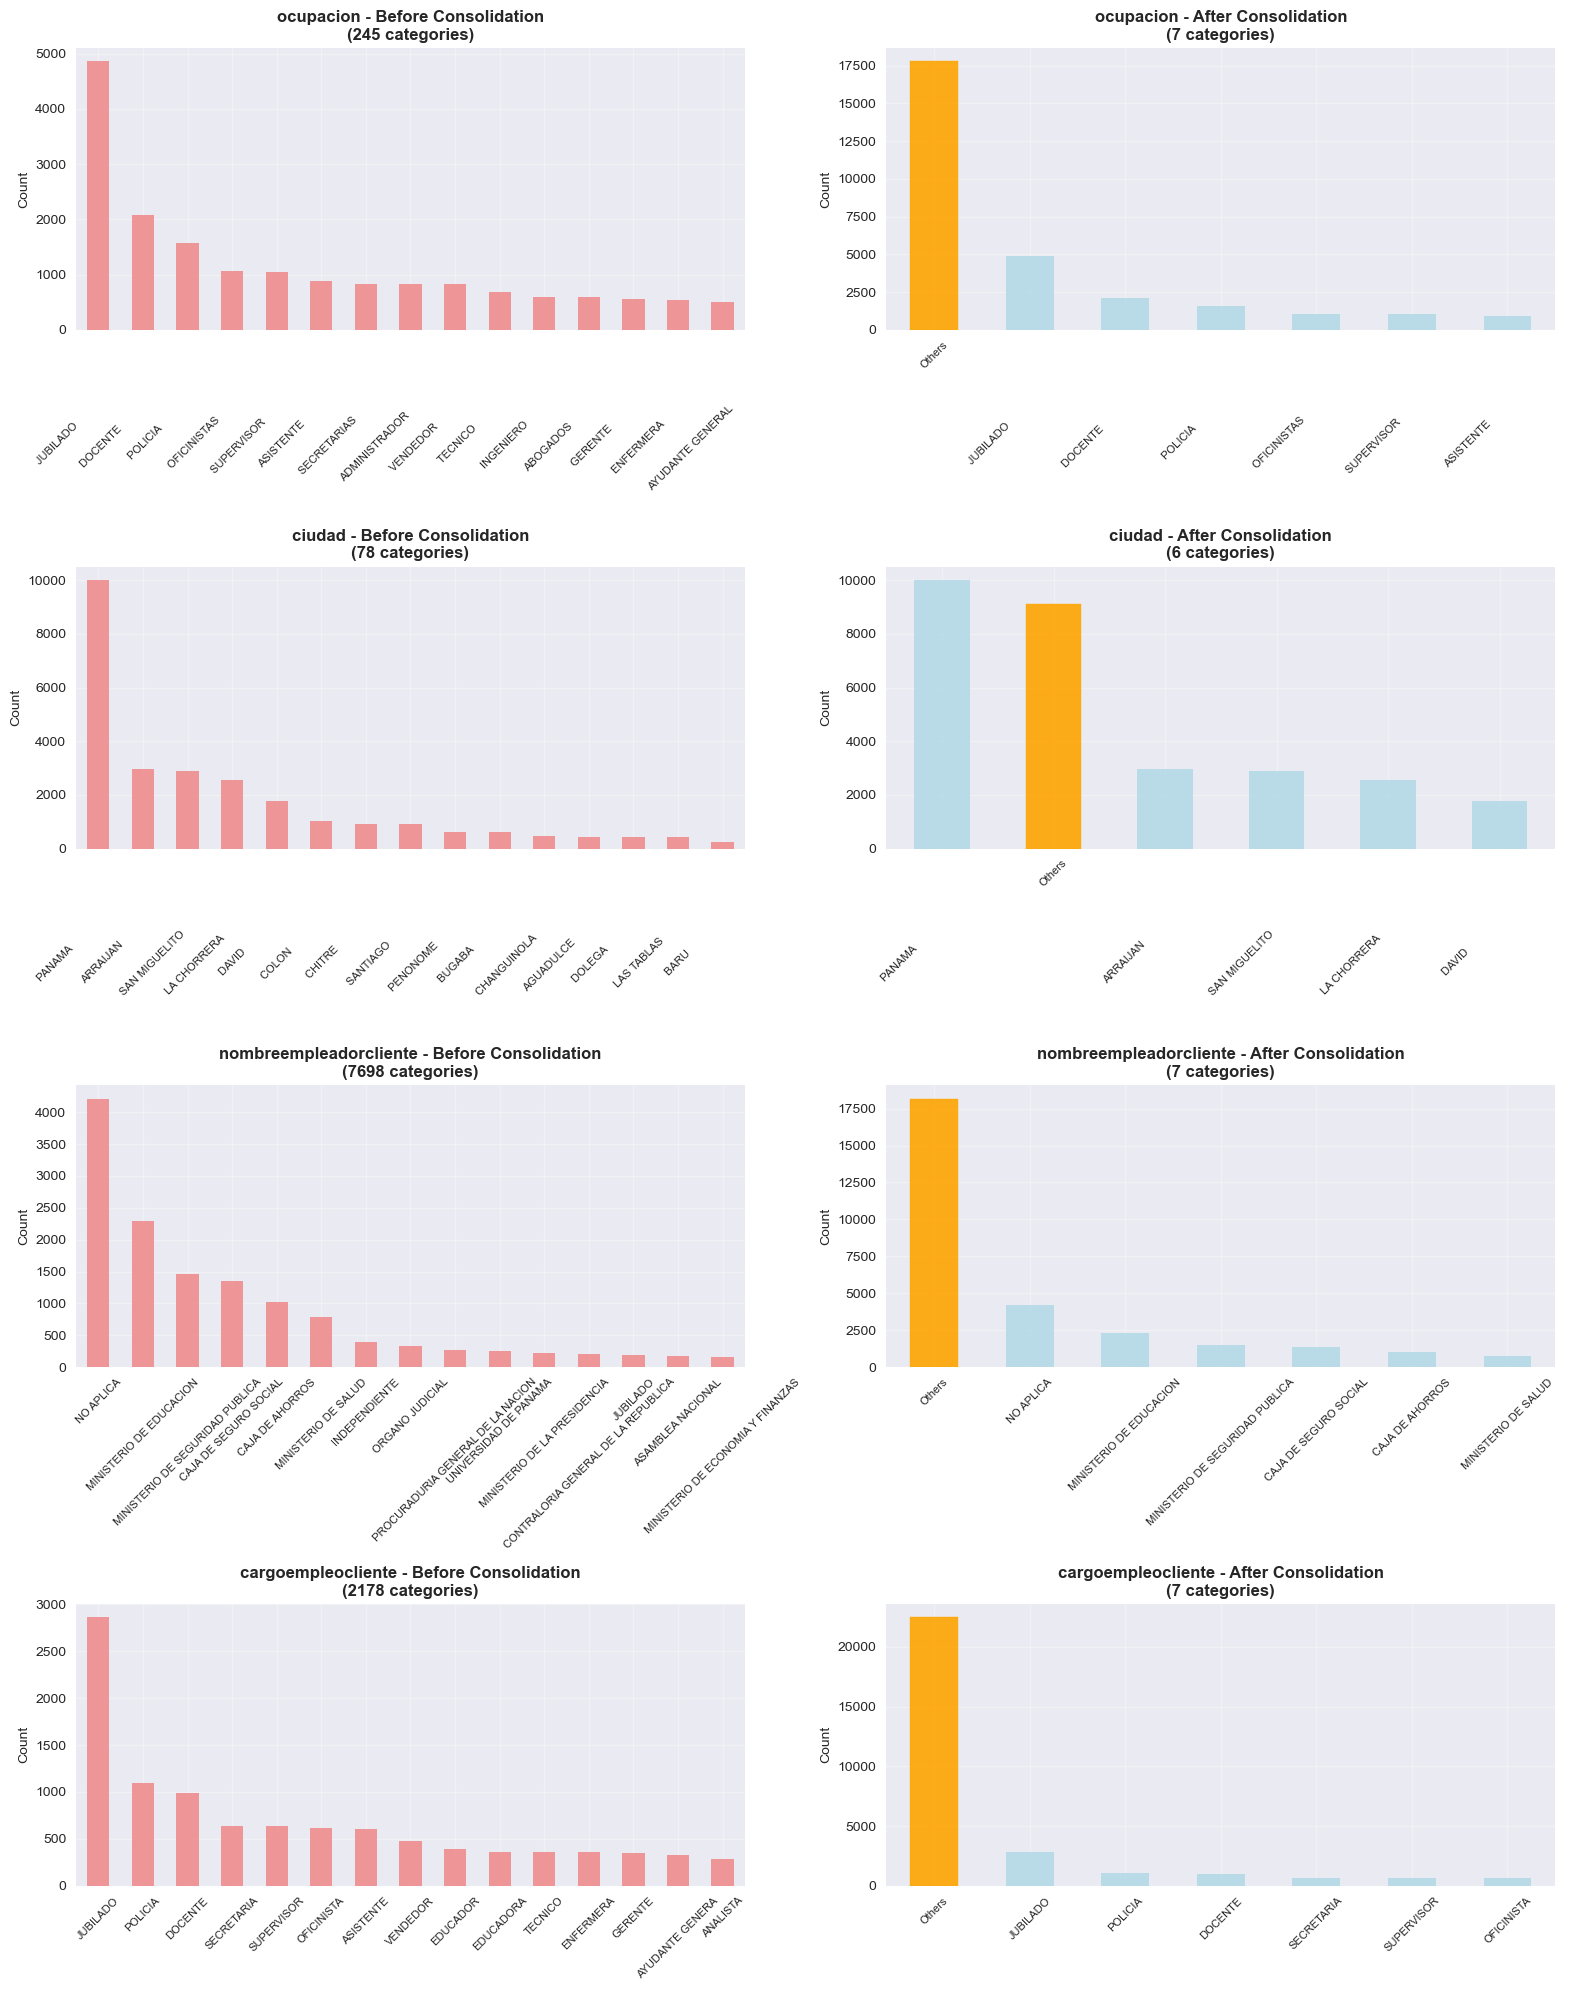


📈 CONSOLIDATION IMPACT SUMMARY:
   ocupacion: 245 → 7 categories (97.1% reduction)
   ciudad: 78 → 6 categories (92.3% reduction)
   nombreempleadorcliente: 7698 → 7 categories (99.9% reduction)
   cargoempleocliente: 2178 → 7 categories (99.7% reduction)

🔧 CREATING df_clientes_consolidated FOR NEXT STEPS
   ✅ Created: ocupacion_consolidated
   ✅ Created: ciudad_consolidated
   ✅ Created: nombreempleadorcliente_consolidated
   ✅ Created: cargoempleocliente_consolidated
   ✅ Created: sexo_consolidated
   ✅ Created: estado_civil_consolidated
   ✅ Created: pais_consolidated

🎯 ULTRA-CONSOLIDATED FEATURES FOR MODELING:
   ocupacion_consolidated: 7 categories
   ciudad_consolidated: 6 categories
   nombreempleadorcliente_consolidated: 7 categories
   cargoempleocliente_consolidated: 7 categories
   sexo_consolidated: 2 categories
   estado_civil_consolidated: 3 categories
   pais_consolidated: 2 categories

💾 DATASET READY:
   df_clientes_consolidated: (29319, 41)
   Ultra-simple categori

In [14]:
# =============================================================================
# ULTRA-SIMPLE CATEGORICAL CONSOLIDATION (COPY-PASTE READY)
# =============================================================================
# 
# OBJECTIVE: Create ultra-simple categorical features (4-5 categories max)
# STRATEGY: Keep only top 3-4 categories, consolidate everything else to 'Others'
# BASED ON: Your actual data analysis results
#
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("🎯 ULTRA-SIMPLE CATEGORICAL CONSOLIDATION")
print("="*80)
print("📋 Objective: Ultra-simple categories (4-5 max) for production stability")
print("🎯 Strategy: Keep only top 3-4 categories, rest → 'Others'")
print("📊 Target: 60-80% coverage with main categories")

# =============================================================================
# ULTRA-AGGRESSIVE CONSOLIDATION FUNCTION
# =============================================================================

def ultra_simple_consolidate(df, column_name, max_categories=4):
    """
    Ultra-aggressive consolidation: Keep only top N categories, rest → 'Others'
    
    Parameters:
    - df: DataFrame (your df_clientes)
    - column_name: Column to consolidate
    - max_categories: Maximum number of categories to keep (excluding 'Others')
    
    Returns:
    - Series with consolidated categories
    """
    print(f"\n🔥 ULTRA-CONSOLIDATION: {column_name}")
    print("="*60)
    
    if column_name not in df.columns:
        print(f"❌ Column '{column_name}' not found!")
        return df[column_name].copy() if column_name in df.columns else None
    
    # Get value counts and percentages
    value_counts = df[column_name].value_counts()
    total_non_null = df[column_name].notna().sum()
    
    print(f"📊 Original state:")
    print(f"   Total non-null values: {total_non_null:,}")
    print(f"   Unique categories: {len(value_counts):,}")
    print(f"   Missing values: {df[column_name].isnull().sum():,}")
    
    # Keep only top N categories
    keep_categories = list(value_counts.head(max_categories).index)
    consolidate_categories = list(value_counts.iloc[max_categories:].index)
    
    # Calculate statistics
    keep_count = sum(value_counts[cat] for cat in keep_categories)
    consolidate_count = sum(value_counts[cat] for cat in consolidate_categories)
    final_coverage = (keep_count / total_non_null) * 100
    
    print(f"\n🎯 Ultra-consolidation result:")
    print(f"   Keep: {len(keep_categories)} categories ({keep_count:,} records, {final_coverage:.1f}%)")
    print(f"   → 'Others': {len(consolidate_categories)} categories ({consolidate_count:,} records, {(100-final_coverage):.1f}%)")
    print(f"   Final categories: {len(keep_categories) + (1 if consolidate_categories else 0)}")
    
    # Show kept categories
    print(f"\n🏆 Categories to KEEP:")
    for i, cat in enumerate(keep_categories, 1):
        count = value_counts[cat]
        pct = (count / total_non_null) * 100
        print(f"   {i}. '{cat}': {count:,} ({pct:.1f}%)")
    
    # Create consolidated column
    consolidated_column = df[column_name].copy()
    
    # Handle categorical dtype
    if pd.api.types.is_categorical_dtype(consolidated_column):
        consolidated_column = consolidated_column.astype(str)
    
    # Handle NaN values
    consolidated_column = consolidated_column.fillna('__MISSING__')
    
    # Create mask for values to replace
    mask = ~consolidated_column.isin(keep_categories)
    mask = mask & (consolidated_column != '__MISSING__')
    
    # Apply consolidation
    consolidated_column.loc[mask] = 'Others'
    
    # Convert missing values back to NaN
    consolidated_column = consolidated_column.replace('__MISSING__', np.nan)
    
    print(f"   ✅ Created ultra-consolidated column")
    
    return consolidated_column

# =============================================================================
# APPLY ULTRA-CONSOLIDATION TO YOUR df_clientes
# =============================================================================

print(f"\n🚀 APPLYING ULTRA-CONSOLIDATION TO df_clientes")
print("="*60)

# Create a copy to work with
df_clientes_ultra = df_clientes.copy()

# =============================================================================
# ANALYZE TOP CATEGORIES TO MAKE INFORMED DECISIONS
# =============================================================================

def analyze_top_categories(df, column_name, top_n=10):
    """
    Show top N categories with their coverage to help decide how many to keep
    """
    print(f"\n🔍 TOP CATEGORIES ANALYSIS: {column_name}")
    print("="*50)

    if column_name not in df.columns:
        print(f"❌ Column '{column_name}' not found!")
        return

    value_counts = df[column_name].value_counts()
    total_non_null = df[column_name].notna().sum()

    print(f"📊 Total categories: {len(value_counts):,}")
    print(f"📊 Total records: {total_non_null:,}")

    cumulative_pct = 0
    print(f"\n🏆 Top {top_n} categories:")
    for i, (cat, count) in enumerate(value_counts.head(top_n).items(), 1):
        pct = (count / total_non_null) * 100
        cumulative_pct += pct
        print(f"   {i:2d}. '{cat[:40]}...': {count:,} ({pct:.1f}%) | Cumulative: {cumulative_pct:.1f}%")

    # Show coverage for different cut-offs
    print(f"\n📈 Coverage analysis:")
    for n in [3, 4, 5, 6, 7, 8]:
        if n <= len(value_counts):
            top_n_count = value_counts.head(n).sum()
            coverage = (top_n_count / total_non_null) * 100
            others_count = total_non_null - top_n_count
            others_pct = (others_count / total_non_null) * 100
            print(f"   Keep top {n}: {coverage:.1f}% coverage, {others_count:,} records ({others_pct:.1f}%) → 'Others'")

# Analyze each categorical feature
categorical_features = ['ocupacion', 'ciudad', 'nombreempleadorcliente', 'cargoempleocliente', 'sexo', 'estado_civil', 'pais']

for feature in categorical_features:
    if feature in df_clientes.columns:
        analyze_top_categories(df_clientes, feature, top_n=8)

print(f"\n🎯 RECOMMENDED CONSOLIDATION RULES (ADJUSTABLE)")
print("="*60)
print("📝 Based on the analysis above, here are suggested rules:")
print("   You can modify these numbers based on what you see!")

# Define flexible rules - YOU CAN MODIFY THESE NUMBERS!
ultra_rules = {
    'ocupacion': 6,           # Keep top 6: JUBILADO, DOCENTE, POLICIA, OFICINISTAS, SUPERVISOR, ASISTENTE
    'ciudad': 5,              # Keep top 5: PANAMA, ARRAIJAN, SAN MIGUELITO, LA CHORRERA, DAVID
    'nombreempleadorcliente': 6,  # Keep top 6: NO APLICA, MIN EDUCACION, MIN SEGURIDAD, CSS, CAJA AHORROS, MIN SALUD
    'cargoempleocliente': 6,  # Keep top 6: JUBILADO, POLICIA, DOCENTE, SUPERVISOR, SECRETARIA, OFICINISTA
    'sexo': 2,                # Keep both: Femenino, Masculino
    'estado_civil': 2,        # Keep top 2: Soltero, Casado
    'pais': 1                 # Keep only: PANAMA
}

print(f"\n📋 CURRENT RULES:")
for feature, max_cats in ultra_rules.items():
    print(f"   {feature}: Keep top {max_cats} categories")

# Apply ultra-consolidation
ultra_results = {}

for column, max_cats in ultra_rules.items():
    if column in df_clientes.columns:
        print(f"\n🔥 Processing: {column} (max {max_cats} categories)")
        
        # Apply ultra-consolidation
        df_clientes_ultra[f"{column}_ultra"] = ultra_simple_consolidate(
            df_clientes, column, max_categories=max_cats
        )
        
        # Store results for validation
        final_counts = df_clientes_ultra[f"{column}_ultra"].value_counts()
        ultra_results[column] = {
            'original_unique': df_clientes[column].nunique(),
            'final_unique': len(final_counts),
            'final_distribution': final_counts.to_dict()
        }
        
        print(f"   ✅ Created: {column}_ultra")
    else:
        print(f"   ⚠️ Column '{column}' not found in df_clientes")

# =============================================================================
# VALIDATION AND SUMMARY
# =============================================================================

print(f"\n✅ ULTRA-CONSOLIDATION VALIDATION")
print("="*60)

for column, result in ultra_results.items():
    ultra_column = f"{column}_ultra"
    
    print(f"\n📊 {column} → {ultra_column}:")
    print(f"   Original categories: {result['original_unique']:,}")
    print(f"   Final categories: {result['final_unique']:,}")
    reduction = ((result['original_unique'] - result['final_unique']) / result['original_unique']) * 100
    print(f"   Reduction: {reduction:.1f}%")
    
    print(f"   Final distribution:")
    total_records = sum(result['final_distribution'].values())
    for cat, count in result['final_distribution'].items():
        pct = (count / total_records) * 100
        print(f"     '{cat}': {count:,} ({pct:.1f}%)")

print(f"\n📈 ULTRA-CONSOLIDATION SUMMARY")
print("="*60)

total_original = sum(r['original_unique'] for r in ultra_results.values())
total_final = sum(r['final_unique'] for r in ultra_results.values())
overall_reduction = ((total_original - total_final) / total_original) * 100

print(f"📊 Overall impact:")
print(f"   Total original categories: {total_original:,}")
print(f"   Total final categories: {total_final:,}")
print(f"   Overall reduction: {overall_reduction:.1f}%")

print(f"\n📋 Per-feature summary:")
for column, result in ultra_results.items():
    reduction = ((result['original_unique'] - result['final_unique']) / result['original_unique']) * 100
    print(f"   {column}: {result['original_unique']:,} → {result['final_unique']:,} categories ({reduction:.1f}% reduction)")

# =============================================================================
# VISUALIZATION: BEFORE/AFTER CONSOLIDATION COMPARISON
# =============================================================================

def visualize_ultra_consolidation_impact(df_original, df_consolidated, ultra_results, max_cols=4):
    """
    Create before/after visualizations for ultra-consolidation
    """
    print(f"\n📊 CREATING BEFORE/AFTER CONSOLIDATION VISUALIZATIONS")
    print("="*60)

    # Select columns to visualize (limit to avoid overcrowding)
    columns_to_plot = list(ultra_results.keys())[:max_cols]

    fig, axes = plt.subplots(len(columns_to_plot), 2, figsize=(16, 5*len(columns_to_plot)))
    if len(columns_to_plot) == 1:
        axes = axes.reshape(1, -1)

    for i, column in enumerate(columns_to_plot):
        # Before consolidation (left side)
        ax1 = axes[i, 0]
        value_counts_original = df_original[column].value_counts().head(15)
        bars1 = value_counts_original.plot(kind='bar', ax=ax1, color='lightcoral', alpha=0.8)
        ax1.set_title(f'{column} - Before Consolidation\n({ultra_results[column]["original_unique"]} categories)',
                     fontweight='bold', fontsize=12)
        ax1.set_xlabel('')
        ax1.set_ylabel('Count', fontsize=10)
        ax1.tick_params(axis='x', rotation=45, labelsize=8)
        ax1.grid(True, alpha=0.3)

        # After consolidation (right side)
        ax2 = axes[i, 1]
        consolidated_col = f"{column}_ultra"
        if consolidated_col in df_consolidated.columns:
            value_counts_consolidated = df_consolidated[consolidated_col].value_counts()
            bars2 = value_counts_consolidated.plot(kind='bar', ax=ax2, color='lightblue', alpha=0.8)

            # Highlight Others category in orange
            if 'Others' in value_counts_consolidated.index:
                others_idx = list(value_counts_consolidated.index).index('Others')
                bars2.patches[others_idx].set_color('orange')
                bars2.patches[others_idx].set_alpha(0.9)

        ax2.set_title(f'{column} - After Consolidation\n({ultra_results[column]["final_unique"]} categories)',
                     fontweight='bold', fontsize=12)
        ax2.set_xlabel('')
        ax2.set_ylabel('Count', fontsize=10)
        ax2.tick_params(axis='x', rotation=45, labelsize=8)
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print reduction summary
    print(f"\n📈 CONSOLIDATION IMPACT SUMMARY:")
    for column in columns_to_plot:
        original = ultra_results[column]["original_unique"]
        final = ultra_results[column]["final_unique"]
        reduction = ((original - final) / original) * 100
        print(f"   {column}: {original} → {final} categories ({reduction:.1f}% reduction)")

# Create the visualization
visualize_ultra_consolidation_impact(df_clientes, df_clientes_ultra, ultra_results)

# =============================================================================
# CREATE df_clientes_consolidated FOR NEXT STEPS
# =============================================================================

print(f"\n🔧 CREATING df_clientes_consolidated FOR NEXT STEPS")
print("="*50)

# Create df_clientes_consolidated with ultra-consolidated columns
df_clientes_consolidated = df_clientes_ultra.copy()

# Rename ultra columns to consolidated for compatibility with your workflow
for column in ultra_rules.keys():
    if f"{column}_ultra" in df_clientes_consolidated.columns:
        df_clientes_consolidated[f"{column}_consolidated"] = df_clientes_consolidated[f"{column}_ultra"]
        # Keep the ultra column for reference but use consolidated for next steps
        print(f"   ✅ Created: {column}_consolidated")

print(f"\n🎯 ULTRA-CONSOLIDATED FEATURES FOR MODELING:")
consolidated_columns = [col for col in df_clientes_consolidated.columns if col.endswith('_consolidated')]
for col in consolidated_columns:
    unique_count = df_clientes_consolidated[col].nunique()
    print(f"   {col}: {unique_count} categories")

print(f"\n💾 DATASET READY:")
print(f"   df_clientes_consolidated: {df_clientes_consolidated.shape}")
print(f"   Ultra-simple categorical features: {len(consolidated_columns)}")

print(f"\n🎉 ULTRA-CONSOLIDATION COMPLETE!")
print("📝 Next steps:")
print("   1. Continue with your notebook workflow")
print("   2. Use the '_consolidated' columns for feature engineering")
print("   3. Apply frequency encoding to these ultra-simple categories")
print("   4. Train your model with production-safe features")


In [15]:
# =============================================================================
# DECISION: PROCEED WITH df_clientes_final ONLY
# =============================================================================

print("🎯 STRATEGIC DECISION: USING df_clientes_final ONLY")
print("="*60)
print("✅ REASONS:")
print("   1. Production simplicity - no external API dependencies")
print("   2. Faster loan application process")
print("   3. Aligns with cross-sectional methodology research")
print("   4. All necessary features available at application time")
print("   5. Reduces operational complexity and risk")

print(f"\n📊 FINAL DATASET FOR MODELING:")
print(f"   Dataset: df_clientes_final")
print(f"   Records: {len(df_clientes_consolidated):,}")
print(f"   Features: {len(df_clientes_consolidated.columns)}")
print(f"   Target: ingresos_reportados")

print(f"\n🚀 NEXT STEPS:")
print("   1. Feature selection and engineering")
print("   2. Train-test split")
print("   3. Model training with multiple algorithms")
print("   4. Model evaluation and selection")
print("   5. Production deployment preparation")

🎯 STRATEGIC DECISION: USING df_clientes_final ONLY
✅ REASONS:
   1. Production simplicity - no external API dependencies
   2. Faster loan application process
   3. Aligns with cross-sectional methodology research
   4. All necessary features available at application time
   5. Reduces operational complexity and risk

📊 FINAL DATASET FOR MODELING:
   Dataset: df_clientes_final
   Records: 29,319
   Features: 41
   Target: ingresos_reportados

🚀 NEXT STEPS:
   1. Feature selection and engineering
   2. Train-test split
   3. Model training with multiple algorithms
   4. Model evaluation and selection
   5. Production deployment preparation


## Check Ids or duplicates values

In [16]:
df_clientes_final = df_clientes_consolidated.copy()

In [17]:
# =============================================================================
# STEP 7: INVESTIGATE ID DISCREPANCY IN df_clientes_final
# =============================================================================

print("🔍 INVESTIGATING ID DISCREPANCY IN df_clientes_final")
print("="*70)
print("🚨 ISSUE: Dataset has ~19,000 records but only ~15,000 unique IDs")
print("📋 Possible causes: Duplicates, missing IDs, or data quality issues")

# =============================================================================
# STEP 7.1: BASIC ID ANALYSIS
# =============================================================================

print(f"\n📊 BASIC ID ANALYSIS")
print("="*40)

total_records = len(df_clientes_final)
total_ids = df_clientes_final['identificador_unico'].nunique()
missing_ids = df_clientes_final['identificador_unico'].isnull().sum()
non_null_ids = df_clientes_final['identificador_unico'].notna().sum()

print(f"Total records in dataset: {total_records:,}")
print(f"Unique identificador_unico: {total_ids:,}")
print(f"Missing identificador_unico: {missing_ids:,}")
print(f"Non-null identificador_unico: {non_null_ids:,}")
print(f"Discrepancy: {total_records - total_ids:,} records")

# Calculate the difference
difference = total_records - total_ids
print(f"\n🔍 ANALYSIS:")
if missing_ids > 0:
    print(f"   • {missing_ids:,} records have missing IDs")
if difference > missing_ids:
    duplicate_records = difference - missing_ids
    print(f"   • {duplicate_records:,} records appear to be duplicates")

# =============================================================================
# STEP 7.2: DUPLICATE ANALYSIS
# =============================================================================

print(f"\n🔍 DUPLICATE ANALYSIS")
print("="*40)

# Check for duplicate IDs
duplicate_mask = df_clientes_final['identificador_unico'].duplicated(keep=False)
duplicate_records = df_clientes_final[duplicate_mask]
unique_duplicate_ids = df_clientes_final[duplicate_mask]['identificador_unico'].nunique()

print(f"Records with duplicate IDs: {len(duplicate_records):,}")
print(f"Unique IDs that have duplicates: {unique_duplicate_ids:,}")

if len(duplicate_records) > 0:
    # Analyze duplicate patterns
    id_counts = df_clientes_final['identificador_unico'].value_counts()
    duplicated_ids = id_counts[id_counts > 1]
    
    print(f"\n📈 DUPLICATE PATTERNS:")
    print(f"   IDs appearing once: {(id_counts == 1).sum():,}")
    print(f"   IDs appearing multiple times: {len(duplicated_ids):,}")
    print(f"   Maximum occurrences: {duplicated_ids.max():,}")
    print(f"   Average occurrences for duplicated IDs: {duplicated_ids.mean():.2f}")
    
    # Show distribution of duplicate counts
    print(f"\n📊 DUPLICATE FREQUENCY DISTRIBUTION:")
    duplicate_freq = duplicated_ids.value_counts().sort_index()
    for freq, count in duplicate_freq.items():
        print(f"   IDs appearing {freq} times: {count:,} IDs")
    
    # Show top duplicated IDs
    print(f"\n🏆 TOP 10 MOST DUPLICATED IDs:")
    for i, (id_val, count) in enumerate(duplicated_ids.head(10).items(), 1):
        print(f"   {i:2d}. {id_val}: {count:,} records")

# =============================================================================
# STEP 7.3: SAMPLE DUPLICATE RECORDS INSPECTION
# =============================================================================

if len(duplicate_records) > 0:
    print(f"\n🔍 SAMPLE DUPLICATE RECORDS INSPECTION")
    print("="*50)
    
    # Get a sample of duplicated IDs for detailed inspection
    sample_duplicate_ids = duplicated_ids.head(3).index.tolist()
    
    for i, sample_id in enumerate(sample_duplicate_ids, 1):
        print(f"\n📋 SAMPLE {i}: ID = {sample_id}")
        print("-" * 30)
        
        sample_records = df_clientes_final[df_clientes_final['identificador_unico'] == sample_id]
        print(f"Number of records: {len(sample_records)}")
        
        # Show key columns to understand differences
        key_columns = ['identificador_unico', 'cliente', 'edad', 'sexo', 'ocupacion', 
                      'ingresos_reportados', 'monto_letra', 'fecha_inicio', 'fecha_vencimiento']
        
        # Only show columns that exist
        available_columns = [col for col in key_columns if col in sample_records.columns]
        
        print("Key fields comparison:")
        display_df = sample_records[available_columns].reset_index(drop=True)
        
        # Show the records
        for idx, row in display_df.iterrows():
            print(f"  Record {idx + 1}:")
            for col in available_columns:
                print(f"    {col}: {row[col]}")
        
        # Check if records are identical
        if len(sample_records) > 1:
            # Compare all columns except index
            cols_to_compare = [col for col in sample_records.columns if col != 'identificador_unico']
            
            # Check if all other columns are identical
            first_record = sample_records.iloc[0][cols_to_compare]
            identical = True
            
            for idx in range(1, len(sample_records)):
                if not sample_records.iloc[idx][cols_to_compare].equals(first_record):
                    identical = False
                    break
            
            if identical:
                print("  🔄 Status: EXACT DUPLICATES (all fields identical)")
            else:
                print("  📊 Status: DIFFERENT DATA (same ID, different information)")
                
                # Find which columns differ
                differing_columns = []
                for col in cols_to_compare:
                    if sample_records[col].nunique() > 1:
                        differing_columns.append(col)
                
                if differing_columns:
                    print(f"  📝 Differing columns: {', '.join(differing_columns)}")

# =============================================================================
# STEP 7.4: MISSING ID ANALYSIS
# =============================================================================

if missing_ids > 0:
    print(f"\n🔍 MISSING ID ANALYSIS")
    print("="*40)
    
    missing_id_records = df_clientes_final[df_clientes_final['identificador_unico'].isnull()]
    
    print(f"Records with missing identificador_unico: {len(missing_id_records):,}")
    
    # Check if these records have other identifying information
    if 'cliente' in missing_id_records.columns:
        missing_with_cliente = missing_id_records['cliente'].notna().sum()
        print(f"Missing ID records with 'cliente' field: {missing_with_cliente:,}")
    
    # Show sample of missing ID records
    print(f"\n📋 SAMPLE MISSING ID RECORDS:")
    sample_missing = missing_id_records.head(3)
    
    display_columns = ['cliente', 'edad', 'sexo', 'ocupacion', 'ingresos_reportados']
    available_display_cols = [col for col in display_columns if col in sample_missing.columns]
    
    for idx, row in sample_missing[available_display_cols].iterrows():
        print(f"  Record {idx}:")
        for col in available_display_cols:
            print(f"    {col}: {row[col]}")

# =============================================================================
# STEP 7.5: DATA QUALITY RECOMMENDATIONS
# =============================================================================

print(f"\n💡 DATA QUALITY RECOMMENDATIONS")
print("="*50)

print(f"🎯 FINDINGS SUMMARY:")
print(f"   • Total records: {total_records:,}")
print(f"   • Unique IDs: {total_ids:,}")
print(f"   • Missing IDs: {missing_ids:,}")
if len(duplicate_records) > 0:
    print(f"   • Duplicate records: {len(duplicate_records):,}")
    print(f"   • IDs with duplicates: {unique_duplicate_ids:,}")

print(f"\n🔧 RECOMMENDED ACTIONS:")

if missing_ids > 0:
    print(f"   1. 🚨 MISSING IDs: Investigate {missing_ids:,} records without identificador_unico")
    print(f"      - Check if these can be matched using other fields")
    print(f"      - Consider removing if no way to identify customers")

if len(duplicate_records) > 0:
    print(f"   2. 🔄 DUPLICATES: Handle {len(duplicate_records):,} duplicate records")
    print(f"      - If exact duplicates: Remove duplicates")
    print(f"      - If different data: Investigate business logic")
    print(f"      - Consider keeping most recent record")

print(f"   3. 📊 VALIDATION: Verify data source and ETL process")
print(f"   4. 🧹 CLEANING: Create clean dataset with unique customers")

print(f"\n🎯 NEXT STEPS:")
print(f"   1. Decide on duplicate handling strategy")
print(f"   2. Clean the dataset to ensure one record per customer")
print(f"   3. Validate that target variable is preserved correctly")
print(f"   4. Proceed with modeling on clean dataset")

# =============================================================================
# STEP 7.6: CREATE SUMMARY STATISTICS
# =============================================================================

print(f"\n📊 SUMMARY STATISTICS")
print("="*40)

summary_stats = {
    'total_records': total_records,
    'unique_ids': total_ids,
    'missing_ids': missing_ids,
    'duplicate_records': len(duplicate_records) if len(duplicate_records) > 0 else 0,
    'ids_with_duplicates': unique_duplicate_ids if len(duplicate_records) > 0 else 0,
    'data_quality_score': ((total_ids / total_records) * 100) if total_records > 0 else 0
}

for key, value in summary_stats.items():
    if key == 'data_quality_score':
        print(f"{key}: {value:.1f}%")
    else:
        print(f"{key}: {value:,}")

print(f"\n💾 SUMMARY STORED IN 'summary_stats' VARIABLE")

🔍 INVESTIGATING ID DISCREPANCY IN df_clientes_final
🚨 ISSUE: Dataset has ~19,000 records but only ~15,000 unique IDs
📋 Possible causes: Duplicates, missing IDs, or data quality issues

📊 BASIC ID ANALYSIS
Total records in dataset: 29,319
Unique identificador_unico: 29,319
Missing identificador_unico: 0
Non-null identificador_unico: 29,319
Discrepancy: 0 records

🔍 ANALYSIS:

🔍 DUPLICATE ANALYSIS
Records with duplicate IDs: 0
Unique IDs that have duplicates: 0

💡 DATA QUALITY RECOMMENDATIONS
🎯 FINDINGS SUMMARY:
   • Total records: 29,319
   • Unique IDs: 29,319
   • Missing IDs: 0

🔧 RECOMMENDED ACTIONS:
   3. 📊 VALIDATION: Verify data source and ETL process
   4. 🧹 CLEANING: Create clean dataset with unique customers

🎯 NEXT STEPS:
   1. Decide on duplicate handling strategy
   2. Clean the dataset to ensure one record per customer
   3. Validate that target variable is preserved correctly
   4. Proceed with modeling on clean dataset

📊 SUMMARY STATISTICS
total_records: 29,319
unique_i

## Duplicate and Cleaning Strategy

In [18]:
# =============================================================================
# STEP 8: DUPLICATE RECORDS VALIDATION AND CLEANING STRATEGY
# =============================================================================

print("🔧 DUPLICATE RECORDS VALIDATION AND CLEANING")
print("="*60)
print("📋 Objective: Analyze and clean 7,354 duplicate records")
print("🎯 Strategy: Identify exact vs different duplicates, then apply cleaning logic")

# =============================================================================
# STEP 8.1: DETAILED DUPLICATE ANALYSIS
# =============================================================================

def analyze_duplicate_types(df, id_column):
    """
    Analyze whether duplicates are exact copies or contain different information
    """
    print(f"\n🔍 DETAILED DUPLICATE TYPE ANALYSIS")
    print("="*50)
    
    # Get all duplicate records
    duplicate_mask = df[id_column].duplicated(keep=False)
    duplicate_records = df[duplicate_mask].copy()
    
    if len(duplicate_records) == 0:
        print("No duplicates found!")
        return None
    
    # Get unique IDs that have duplicates
    duplicate_ids = duplicate_records[id_column].unique()
    
    print(f"Total duplicate records: {len(duplicate_records):,}")
    print(f"Unique IDs with duplicates: {len(duplicate_ids):,}")
    
    # Analyze each duplicated ID
    exact_duplicates = []
    different_data_duplicates = []
    
    # Columns to exclude from comparison (typically index, timestamps, etc.)
    exclude_columns = [id_column]  # We'll exclude the ID column from comparison
    comparison_columns = [col for col in df.columns if col not in exclude_columns]
    
    print(f"\n🔍 Analyzing {len(duplicate_ids):,} duplicated IDs...")
    
    for i, dup_id in enumerate(duplicate_ids):
        if i % 1000 == 0:  # Progress indicator
            print(f"   Processed {i:,}/{len(duplicate_ids):,} IDs...")
        
        # Get all records for this ID
        id_records = duplicate_records[duplicate_records[id_column] == dup_id]
        
        if len(id_records) <= 1:
            continue
        
        # Check if all records are identical (excluding the ID column)
        first_record = id_records.iloc[0][comparison_columns]
        is_exact_duplicate = True
        
        for idx in range(1, len(id_records)):
            current_record = id_records.iloc[idx][comparison_columns]
            
            # Compare records (handling NaN values properly)
            if not first_record.equals(current_record):
                # Check if differences are only due to NaN handling
                try:
                    # Fill NaN with a placeholder for comparison
                    first_filled = first_record.fillna('__NULL__')
                    current_filled = current_record.fillna('__NULL__')
                    
                    if not first_filled.equals(current_filled):
                        is_exact_duplicate = False
                        break
                except:
                    is_exact_duplicate = False
                    break
        
        if is_exact_duplicate:
            exact_duplicates.append(dup_id)
        else:
            different_data_duplicates.append(dup_id)
    
    print(f"\n📊 DUPLICATE CLASSIFICATION RESULTS:")
    print(f"   Exact duplicates (same data): {len(exact_duplicates):,} IDs")
    print(f"   Different data duplicates: {len(different_data_duplicates):,} IDs")
    
    # Calculate record counts
    exact_duplicate_records = duplicate_records[duplicate_records[id_column].isin(exact_duplicates)]
    different_data_records = duplicate_records[duplicate_records[id_column].isin(different_data_duplicates)]
    
    print(f"\n📈 RECORD COUNTS:")
    print(f"   Exact duplicate records: {len(exact_duplicate_records):,}")
    print(f"   Different data records: {len(different_data_records):,}")
    
    return {
        'exact_duplicate_ids': exact_duplicates,
        'different_data_ids': different_data_duplicates,
        'exact_duplicate_records': exact_duplicate_records,
        'different_data_records': different_data_records,
        'comparison_columns': comparison_columns
    }

# Perform duplicate analysis
duplicate_analysis = analyze_duplicate_types(df_clientes_final, 'identificador_unico')

🔧 DUPLICATE RECORDS VALIDATION AND CLEANING
📋 Objective: Analyze and clean 7,354 duplicate records
🎯 Strategy: Identify exact vs different duplicates, then apply cleaning logic

🔍 DETAILED DUPLICATE TYPE ANALYSIS
No duplicates found!


In [19]:
# =============================================================================
# STEP 8.2: INVESTIGATE DIFFERENT DATA DUPLICATES
# =============================================================================

if duplicate_analysis and len(duplicate_analysis['different_data_ids']) > 0:
    print(f"\n🔍 INVESTIGATING DIFFERENT DATA DUPLICATES")
    print("="*50)
    
    def investigate_different_data_duplicates(df, duplicate_analysis, sample_size=5):
        """
        Investigate what makes different data duplicates different
        """
        different_ids = duplicate_analysis['different_data_ids'][:sample_size]
        comparison_columns = duplicate_analysis['comparison_columns']
        
        print(f"📋 Analyzing {len(different_ids)} sample IDs with different data:")
        
        differing_columns_summary = {}
        
        for i, dup_id in enumerate(different_ids, 1):
            print(f"\n🔍 SAMPLE {i}: ID = {dup_id}")
            print("-" * 40)
            
            # Get all records for this ID
            id_records = df[df['identificador_unico'] == dup_id].copy()
            print(f"Number of records: {len(id_records)}")
            
            # Find columns that differ
            differing_columns = []
            for col in comparison_columns:
                if col in id_records.columns:
                    unique_values = id_records[col].nunique()
                    if unique_values > 1:
                        differing_columns.append(col)
            
            print(f"Columns with different values: {differing_columns}")
            
            # Track overall differing columns
            for col in differing_columns:
                if col not in differing_columns_summary:
                    differing_columns_summary[col] = 0
                differing_columns_summary[col] += 1
            
            # Show the differing data
            if differing_columns:
                print("Differing values:")
                key_columns = ['identificador_unico'] + differing_columns[:10]  # Limit to first 10 differing columns
                available_columns = [col for col in key_columns if col in id_records.columns]
                
                for idx, row in id_records[available_columns].iterrows():
                    print(f"  Record {idx}:")
                    for col in available_columns:
                        if col != 'identificador_unico':
                            print(f"    {col}: {row[col]}")
        
        # Summary of most common differing columns
        if differing_columns_summary:
            print(f"\n📊 MOST COMMON DIFFERING COLUMNS:")
            sorted_differing = sorted(differing_columns_summary.items(), key=lambda x: x[1], reverse=True)
            for col, count in sorted_differing[:10]:
                print(f"   {col}: differs in {count}/{len(different_ids)} samples")
        
        return differing_columns_summary
    
    differing_columns_summary = investigate_different_data_duplicates(
        df_clientes_final, duplicate_analysis, sample_size=5
    )


In [20]:
# =============================================================================
# STEP 8.3: CLEANING STRATEGY DECISION
# =============================================================================

print(f"\n🎯 CLEANING STRATEGY DECISION")
print("="*50)

if duplicate_analysis:
    exact_count = len(duplicate_analysis['exact_duplicate_ids'])
    different_count = len(duplicate_analysis['different_data_ids'])
    
    print(f"📊 DUPLICATE BREAKDOWN:")
    print(f"   Exact duplicates: {exact_count:,} IDs")
    print(f"   Different data: {different_count:,} IDs")
    
    print(f"\n🔧 RECOMMENDED CLEANING ACTIONS:")
    
    if exact_count > 0:
        exact_records = len(duplicate_analysis['exact_duplicate_records'])
        print(f"   1. EXACT DUPLICATES ({exact_count:,} IDs, {exact_records:,} records):")
        print(f"      ✅ Action: Remove duplicates, keep first occurrence")
        print(f"      📉 Will remove: {exact_records - exact_count:,} records")
    
    if different_count > 0:
        different_records = len(duplicate_analysis['different_data_records'])
        print(f"   2. DIFFERENT DATA ({different_count:,} IDs, {different_records:,} records):")
        print(f"      🤔 Action: Requires business logic decision")
        print(f"      📋 Options:")
        print(f"         a) Keep most recent record (if date available)")
        print(f"         b) Keep record with most complete data")
        print(f"         c) Keep record with highest income (for income modeling)")
        print(f"         d) Manual review and business rule definition")



🎯 CLEANING STRATEGY DECISION


In [21]:
# =============================================================================
# STEP 8.4: IMPLEMENT CLEANING FUNCTIONS
# =============================================================================

def remove_exact_duplicates(df, id_column, duplicate_analysis):
    """
    Remove exact duplicate records, keeping the first occurrence
    """
    print(f"\n🧹 REMOVING EXACT DUPLICATES")
    print("="*40)
    
    if not duplicate_analysis or len(duplicate_analysis['exact_duplicate_ids']) == 0:
        print("No exact duplicates to remove.")
        return df.copy()
    
    exact_ids = duplicate_analysis['exact_duplicate_ids']
    
    # Create a copy of the dataframe
    df_cleaned = df.copy()
    
    # For exact duplicates, keep only the first occurrence
    exact_duplicate_mask = df_cleaned[id_column].isin(exact_ids)
    exact_duplicate_records = df_cleaned[exact_duplicate_mask]
    
    # Remove duplicates for exact duplicate IDs only
    df_exact_cleaned = exact_duplicate_records.drop_duplicates(subset=[id_column], keep='first')
    
    # Combine with non-duplicate records
    non_duplicate_records = df_cleaned[~exact_duplicate_mask]
    df_cleaned = pd.concat([non_duplicate_records, df_exact_cleaned], ignore_index=True)
    
    removed_count = len(df) - len(df_cleaned)
    print(f"✅ Removed {removed_count:,} exact duplicate records")
    print(f"📊 Dataset size: {len(df):,} → {len(df_cleaned):,} records")
    
    return df_cleaned

def handle_different_data_duplicates(df, id_column, duplicate_analysis, strategy='most_recent'):
    """
    Handle duplicates with different data using specified strategy
    """
    print(f"\n🔧 HANDLING DIFFERENT DATA DUPLICATES")
    print("="*40)
    
    if not duplicate_analysis or len(duplicate_analysis['different_data_ids']) == 0:
        print("No different data duplicates to handle.")
        return df.copy()
    
    different_ids = duplicate_analysis['different_data_ids']
    print(f"Processing {len(different_ids):,} IDs with different data...")
    
    df_cleaned = df.copy()
    
    if strategy == 'most_recent':
        # Keep the record with the most recent date (if available)
        date_columns = [col for col in df.columns if 'fecha' in col.lower() or 'date' in col.lower()]
        
        if date_columns:
            print(f"📅 Using most recent strategy based on: {date_columns}")
            
            # For each different data ID, keep the most recent record
            records_to_keep = []
            
            for dup_id in different_ids:
                id_records = df_cleaned[df_cleaned[id_column] == dup_id].copy()
                
                # Find the most recent record
                most_recent_idx = None
                for date_col in date_columns:
                    if date_col in id_records.columns:
                        # Convert to datetime if not already
                        try:
                            id_records[date_col] = pd.to_datetime(id_records[date_col], errors='coerce')
                            # Get the record with the maximum date
                            max_date_idx = id_records[date_col].idxmax()
                            if pd.notna(id_records.loc[max_date_idx, date_col]):
                                most_recent_idx = max_date_idx
                                break
                        except:
                            continue
                
                # If we found a most recent record, keep it; otherwise keep the first
                if most_recent_idx is not None:
                    records_to_keep.append(most_recent_idx)
                else:
                    records_to_keep.append(id_records.index[0])
            
            # Remove all different data duplicates and add back the selected records
            different_data_mask = df_cleaned[id_column].isin(different_ids)
            non_different_records = df_cleaned[~different_data_mask]
            selected_records = df_cleaned.loc[records_to_keep]
            
            df_cleaned = pd.concat([non_different_records, selected_records], ignore_index=True)
            
        else:
            print("⚠️  No date columns found, keeping first occurrence")
            # Fallback: keep first occurrence
            different_data_mask = df_cleaned[id_column].isin(different_ids)
            different_data_records = df_cleaned[different_data_mask]
            df_different_cleaned = different_data_records.drop_duplicates(subset=[id_column], keep='first')
            
            non_different_records = df_cleaned[~different_data_mask]
            df_cleaned = pd.concat([non_different_records, df_different_cleaned], ignore_index=True)
    
    elif strategy == 'most_complete':
        print("📊 Using most complete data strategy...")
        # Keep the record with the least missing values
        records_to_keep = []
        
        for dup_id in different_ids:
            id_records = df_cleaned[df_cleaned[id_column] == dup_id].copy()
            
            # Calculate missing values for each record
            missing_counts = id_records.isnull().sum(axis=1)
            most_complete_idx = missing_counts.idxmin()
            records_to_keep.append(most_complete_idx)
        
        # Remove all different data duplicates and add back the selected records
        different_data_mask = df_cleaned[id_column].isin(different_ids)
        non_different_records = df_cleaned[~different_data_mask]
        selected_records = df_cleaned.loc[records_to_keep]
        
        df_cleaned = pd.concat([non_different_records, selected_records], ignore_index=True)
    
    elif strategy == 'highest_income':
        print("💰 Using highest income strategy...")
        # Keep the record with the highest reported income
        if 'ingresos_reportados' in df_cleaned.columns:
            records_to_keep = []
            
            for dup_id in different_ids:
                id_records = df_cleaned[df_cleaned[id_column] == dup_id].copy()
                
                # Get the record with highest income (excluding NaN)
                income_records = id_records.dropna(subset=['ingresos_reportados'])
                if len(income_records) > 0:
                    highest_income_idx = income_records['ingresos_reportados'].idxmax()
                    records_to_keep.append(highest_income_idx)
                else:
                    # If no income data, keep first
                    records_to_keep.append(id_records.index[0])
            
            # Remove all different data duplicates and add back the selected records
            different_data_mask = df_cleaned[id_column].isin(different_ids)
            non_different_records = df_cleaned[~different_data_mask]
            selected_records = df_cleaned.loc[records_to_keep]
            
            df_cleaned = pd.concat([non_different_records, selected_records], ignore_index=True)
        else:
            print("⚠️  Income column not found, keeping first occurrence")
            # Fallback to first occurrence
            different_data_mask = df_cleaned[id_column].isin(different_ids)
            different_data_records = df_cleaned[different_data_mask]
            df_different_cleaned = different_data_records.drop_duplicates(subset=[id_column], keep='first')
            
            non_different_records = df_cleaned[~different_data_mask]
            df_cleaned = pd.concat([non_different_records, df_different_cleaned], ignore_index=True)
    
    removed_count = len(df) - len(df_cleaned)
    print(f"✅ Processed different data duplicates")
    print(f"📊 Dataset size: {len(df):,} → {len(df_cleaned):,} records")
    
    return df_cleaned


In [22]:
# =============================================================================
# STEP 8.5: EXECUTE CLEANING PROCESS
# =============================================================================

print(f"\n🚀 EXECUTING CLEANING PROCESS")
print("="*50)

# Step 1: Remove exact duplicates
df_step1 = remove_exact_duplicates(df_clientes_final, 'identificador_unico', duplicate_analysis)

# Step 2: Handle different data duplicates
# Choose your strategy: 'most_recent', 'most_complete', or 'highest_income'
print(f"\n🤔 CHOOSE STRATEGY FOR DIFFERENT DATA DUPLICATES:")
print(f"   1. 'most_recent' - Keep record with most recent date")
print(f"   2. 'most_complete' - Keep record with least missing values")
print(f"   3. 'highest_income' - Keep record with highest income (best for income modeling)")

# For income modeling, 'highest_income' makes the most sense
chosen_strategy = 'highest_income'
print(f"\n✅ USING STRATEGY: {chosen_strategy}")

df_cleaned = handle_different_data_duplicates(df_step1, 'identificador_unico', duplicate_analysis, chosen_strategy)


🚀 EXECUTING CLEANING PROCESS

🧹 REMOVING EXACT DUPLICATES
No exact duplicates to remove.

🤔 CHOOSE STRATEGY FOR DIFFERENT DATA DUPLICATES:
   1. 'most_recent' - Keep record with most recent date
   2. 'most_complete' - Keep record with least missing values
   3. 'highest_income' - Keep record with highest income (best for income modeling)

✅ USING STRATEGY: highest_income

🔧 HANDLING DIFFERENT DATA DUPLICATES
No different data duplicates to handle.


In [23]:
# =============================================================================
# STEP 8.6: FINAL VALIDATION
# =============================================================================

print(f"\n✅ FINAL VALIDATION")
print("="*40)

original_records = len(df_clientes_final)
cleaned_records = len(df_cleaned)
unique_ids_cleaned = df_cleaned['identificador_unico'].nunique()
remaining_duplicates = df_cleaned['identificador_unico'].duplicated().sum()

print(f"📊 CLEANING RESULTS:")
print(f"   Original records: {original_records:,}")
print(f"   Cleaned records: {cleaned_records:,}")
print(f"   Records removed: {original_records - cleaned_records:,}")
print(f"   Unique IDs: {unique_ids_cleaned:,}")
print(f"   Remaining duplicates: {remaining_duplicates:,}")

if remaining_duplicates == 0:
    print(f"   ✅ SUCCESS: No remaining duplicates!")
else:
    print(f"   ⚠️  WARNING: {remaining_duplicates:,} duplicates still remain")

# Validate target variable preservation
if 'ingresos_reportados' in df_cleaned.columns:
    original_income_records = df_clientes_final['ingresos_reportados'].notna().sum()
    cleaned_income_records = df_cleaned['ingresos_reportados'].notna().sum()
    
    print(f"\n💰 TARGET VARIABLE VALIDATION:")
    print(f"   Original income records: {original_income_records:,}")
    print(f"   Cleaned income records: {cleaned_income_records:,}")
    print(f"   Income records preserved: {cleaned_income_records/original_income_records*100:.1f}%")

# Store the cleaned dataset
df_clientes_clean = df_cleaned.copy()

print(f"\n💾 CLEANED DATASET STORED AS: df_clientes_clean")
print(f"🎉 READY FOR FEATURE ENGINEERING AND MODELING!")


✅ FINAL VALIDATION
📊 CLEANING RESULTS:
   Original records: 29,319
   Cleaned records: 29,319
   Records removed: 0
   Unique IDs: 29,319
   Remaining duplicates: 0
   ✅ SUCCESS: No remaining duplicates!

💰 TARGET VARIABLE VALIDATION:
   Original income records: 29,319
   Cleaned income records: 29,319
   Income records preserved: 100.0%

💾 CLEANED DATASET STORED AS: df_clientes_clean
🎉 READY FOR FEATURE ENGINEERING AND MODELING!


In [24]:
# path to save C:\Users\david\OneDrive\Documents\augment-projects\caja-de-ahorros\data\processed
path_to_save = r'C:\Users\david\OneDrive\Documents\augment-projects\caja-de-ahorros\data\processed'


In [25]:
auditory_path = r'C:\Users\david\OneDrive\Documents\augment-projects\caja-de-ahorros\auditory_datasets'

In [26]:
#save df_clientes_clean to auditory dataset folder 
df_clientes_clean.to_csv(auditory_path + '\df_clientes_clean_final.csv', index=False)

In [ ]:
#save df_clientes_clean to csv
df_clientes_clean.to_csv(path_to_save + '\df_clientes_clean_final.csv', index=False)

In [ ]:
df_clientes_clean

📊 Creating Before/After Consolidation Visualization...
   ocupacion: 245 → 7 categories (97.1% reduction)
   ciudad: 78 → 6 categories (92.3% reduction)
   nombreempleadorcliente: 7698 → 7 categories (99.9% reduction)
   cargoempleocliente: 2178 → 7 categories (99.7% reduction)


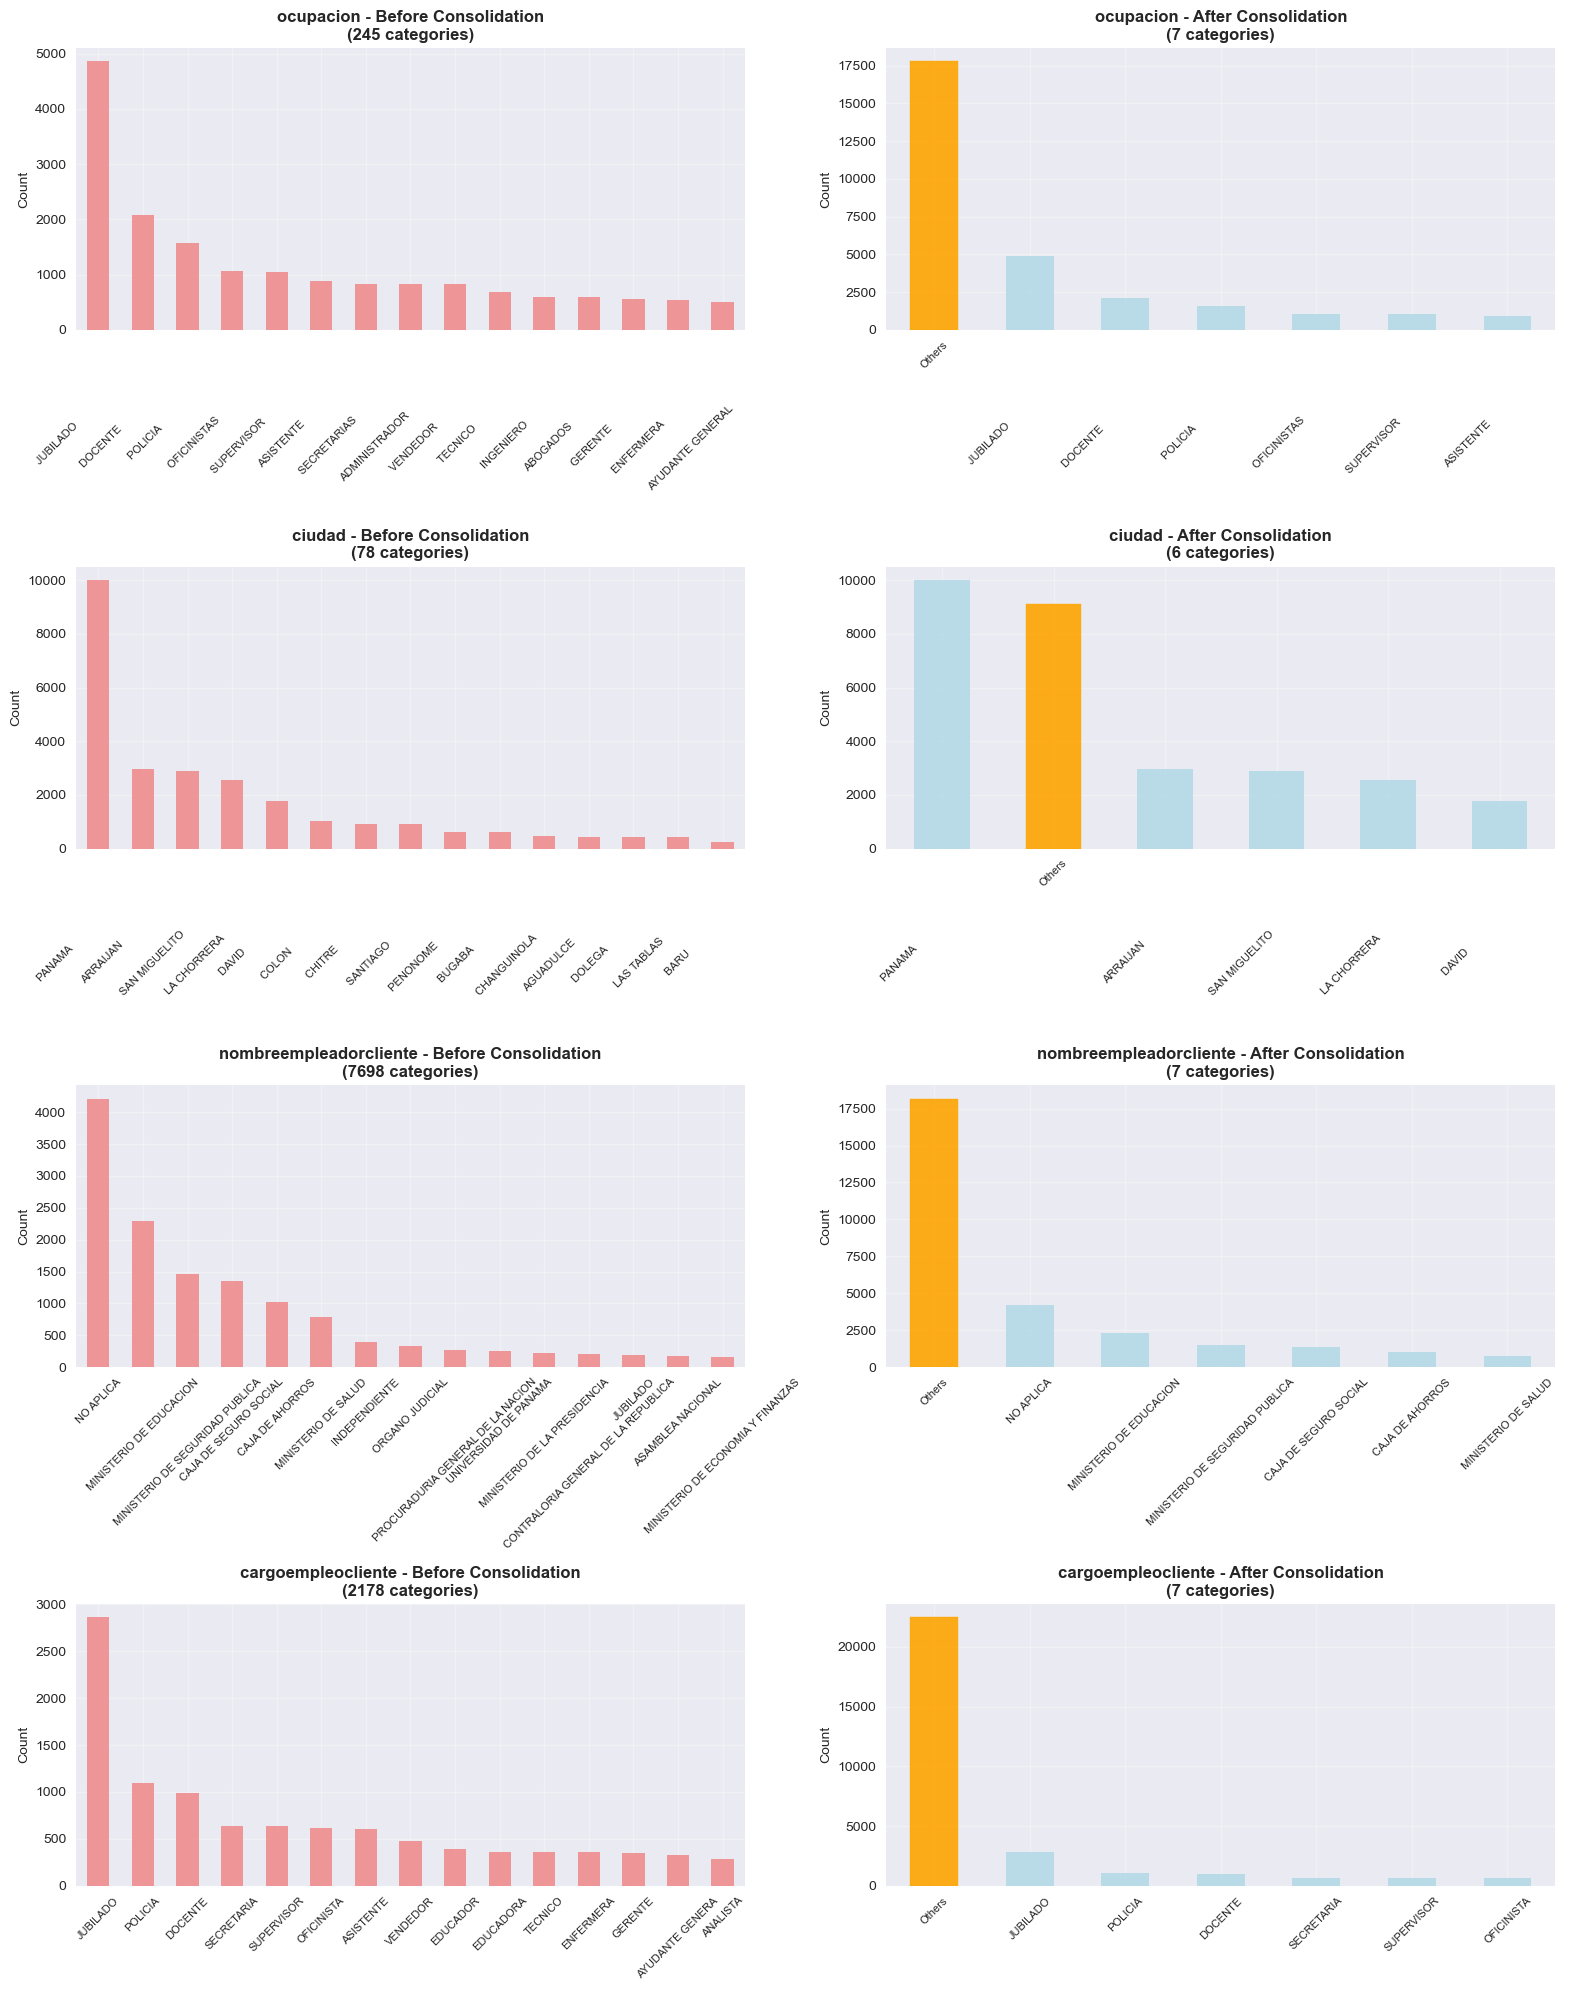


📈 CONSOLIDATION SUMMARY:
   ocupacion:
     Categories: 245 → 7
     'Others': 17,786 records (60.7%)
   ciudad:
     Categories: 78 → 6
     'Others': 9,123 records (31.1%)
   nombreempleadorcliente:
     Categories: 7698 → 7
     'Others': 18,175 records (62.0%)
   cargoempleocliente:
     Categories: 2178 → 7
     'Others': 22,475 records (76.7%)

🎯 OVERALL IMPACT:
   Total categories: 10199 → 27
   Overall reduction: 99.7%


In [27]:
# =============================================================================
# BEFORE/AFTER CONSOLIDATION VISUALIZATION
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_consolidation_comparison(df_clean):
    """
    Create before/after consolidation visualization
    """
    print("📊 Creating Before/After Consolidation Visualization...")
    
    # Define the categorical features to visualize
    features_to_plot = ['ocupacion', 'ciudad', 'nombreempleadorcliente', 'cargoempleocliente']
    
    # Create the plot
    fig, axes = plt.subplots(len(features_to_plot), 2, figsize=(16, 5*len(features_to_plot)))
    
    for i, feature in enumerate(features_to_plot):
        original_col = feature
        consolidated_col = f"{feature}_consolidated"
        
        if original_col in df_clean.columns and consolidated_col in df_clean.columns:
            
            # BEFORE (Left side) - Original categories
            ax1 = axes[i, 0]
            original_counts = df_clean[original_col].value_counts().head(15)
            original_unique = df_clean[original_col].nunique()
            
            bars1 = original_counts.plot(kind='bar', ax=ax1, color='lightcoral', alpha=0.8)
            ax1.set_title(f'{feature} - Before Consolidation\n({original_unique} categories)', 
                         fontweight='bold', fontsize=12)
            ax1.set_xlabel('')
            ax1.set_ylabel('Count', fontsize=10)
            ax1.tick_params(axis='x', rotation=45, labelsize=8)
            ax1.grid(True, alpha=0.3)
            
            # AFTER (Right side) - Consolidated categories
            ax2 = axes[i, 1]
            consolidated_counts = df_clean[consolidated_col].value_counts()
            consolidated_unique = df_clean[consolidated_col].nunique()
            
            bars2 = consolidated_counts.plot(kind='bar', ax=ax2, color='lightblue', alpha=0.8)
            
            # Highlight "Others" category in orange
            if 'Others' in consolidated_counts.index:
                others_idx = list(consolidated_counts.index).index('Others')
                bars2.patches[others_idx].set_color('orange')
                bars2.patches[others_idx].set_alpha(0.9)
            
            ax2.set_title(f'{feature} - After Consolidation\n({consolidated_unique} categories)', 
                         fontweight='bold', fontsize=12)
            ax2.set_xlabel('')
            ax2.set_ylabel('Count', fontsize=10)
            ax2.tick_params(axis='x', rotation=45, labelsize=8)
            ax2.grid(True, alpha=0.3)
            
            # Print reduction info
            reduction_pct = ((original_unique - consolidated_unique) / original_unique) * 100
            print(f"   {feature}: {original_unique} → {consolidated_unique} categories ({reduction_pct:.1f}% reduction)")
        
        else:
            print(f"   ⚠️ Columns not found for {feature}")
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📈 CONSOLIDATION SUMMARY:")
    total_original = 0
    total_final = 0
    
    for feature in features_to_plot:
        original_col = feature
        consolidated_col = f"{feature}_consolidated"
        
        if original_col in df_clean.columns and consolidated_col in df_clean.columns:
            original_unique = df_clean[original_col].nunique()
            consolidated_unique = df_clean[consolidated_col].nunique()
            total_original += original_unique
            total_final += consolidated_unique
            
            # Show Others percentage
            others_count = (df_clean[consolidated_col] == 'Others').sum()
            total_records = df_clean[consolidated_col].notna().sum()
            others_pct = (others_count / total_records) * 100
            
            print(f"   {feature}:")
            print(f"     Categories: {original_unique} → {consolidated_unique}")
            print(f"     'Others': {others_count:,} records ({others_pct:.1f}%)")
    
    overall_reduction = ((total_original - total_final) / total_original) * 100
    print(f"\n🎯 OVERALL IMPACT:")
    print(f"   Total categories: {total_original} → {total_final}")
    print(f"   Overall reduction: {overall_reduction:.1f}%")

# Create the visualization
visualize_consolidation_comparison(df_clientes_clean)